# Data Collection and Preparation

## Environment Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gymnasium
!pip install stable-baselines3[extra]
!pip install statsmodels

!pip install mplcyberpunk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import locale
import os

# Function for setting seeds
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set locale to UTF-8
if locale.getpreferredencoding() != 'UTF-8':
    os.environ['LC_ALL'] = 'en_US.UTF-8'
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Add a better-looking style
import mplcyberpunk
plt.style.use("cyberpunk")

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)


GPU is available


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


## Stock Price Data

In [ ]:
import pandas as pd
import numpy as np
import os

# Read the raw data files
base_path = '/content/drive/MyDrive/Dissertation/Raw Price Data'
companies = ['AMD', 'NVDA']
years = range(2019, 2025)

# Create a list
all_data = []

# Read and combine
for company in companies:
    for year in years:
        file_path = os.path.join(base_path, f'{company}_{year}.csv')
        if os.path.exists(file_path):
            data = pd.read_csv(file_path, parse_dates=['DateTime'])
            data['Company'] = company  # add company name
            all_data.append(data)
        else:
            print(f'File not found: {file_path}')

# Combine
merged_data = pd.concat(all_data)

# Save the processed data file
output_file_path = os.path.join('/content/drive/MyDrive/Dissertation/Processed Data', 'data_merged.csv')
merged_data.to_csv(output_file_path, index=False)


In [ ]:
# Print head
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/data_merged.csv')
print(df.head())

   Unnamed: 0             DateTime   Open   High    Low  Close  Volume Company
0           0  2019-01-02 04:00:00  18.09  18.09  18.00  18.00    2054     AMD
1           1  2019-01-02 04:01:00  17.82  17.82  17.82  17.82     100     AMD
2           2  2019-01-02 04:02:00  18.00  18.15  17.93  17.93    1100     AMD
3           3  2019-01-02 04:03:00  18.00  18.00  18.00  18.00    1000     AMD
4           4  2019-01-02 04:04:00  17.94  17.94  17.94  17.94     100     AMD


In [ ]:
# Print existing lines for both companies
print(f"Total number of rows: {len(df)}, AMD rows: {len(df[df['Company'] == 'AMD'])}, NVDA rows: {len(df[df['Company'] == 'NVDA'])}")

# Print time period
start_time = df['DateTime'].min()
end_time = df['DateTime'].max()

print(f"Start time: {start_time}, End time: {end_time}")

Total number of rows: 1843425, AMD rows: 963807, NVDA rows: 879618
Start time: 2019-01-02 04:00:00, End time: 2024-03-28 19:55:00


In [ ]:
# Read the file again
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/data_merged.csv', parse_dates=['DateTime'])

# Create a complete time index covering the full time range
start_time = df['DateTime'].min()
end_time = df['DateTime'].max()
full_time_index = pd.date_range(start=start_time, end=end_time, freq='T')

# Function to fill missing minutes
def fill_missing_minutes(group):
    group = group.set_index('DateTime').reindex(full_time_index)
    group['Company'] = group['Company'].fillna(method='ffill')
    group['Open'] = group['Open'].fillna(method='ffill')
    group['High'] = group['High'].fillna(method='ffill')
    group['Low'] = group['Low'].fillna(method='ffill')
    group['Close'] = group['Close'].fillna(method='ffill')
    group['Volume'] = group['Volume'].fillna(0)
    return group.reset_index().rename(columns={'index': 'DateTime'})

# Group by company and fill missing minutes
filled_df = df.groupby('Company').apply(fill_missing_minutes).reset_index(drop=True)

# Save the time-filled data
output_file_path = '/content/drive/MyDrive/Dissertation/Processed Data/data_time_filled.csv'
filled_df.to_csv(output_file_path, index=False)

In [ ]:
# Check the data again
print(filled_df.head())
print(f"Total number of rows: {len(filled_df)}, AMD rows: {len(filled_df[filled_df['Company'] == 'AMD'])}, NVDA rows: {len(filled_df[filled_df['Company'] == 'NVDA'])}")
print(f"Start time: {filled_df['DateTime'].min()}, End time: {filled_df['DateTime'].max()}")


             DateTime  Unnamed: 0   Open   High    Low  Close  Volume Company
0 2019-01-02 04:00:00         0.0  18.09  18.09  18.00  18.00  2054.0     AMD
1 2019-01-02 04:01:00         1.0  17.82  17.82  17.82  17.82   100.0     AMD
2 2019-01-02 04:02:00         2.0  18.00  18.15  17.93  17.93  1100.0     AMD
3 2019-01-02 04:03:00         3.0  18.00  18.00  18.00  18.00  1000.0     AMD
4 2019-01-02 04:04:00         4.0  17.94  17.94  17.94  17.94   100.0     AMD
Total number of rows: 5508472, AMD rows: 2754236, NVDA rows: 2754236
Start time: 2019-01-02 04:00:00, End time: 2024-03-28 19:55:00


## Financial Indexes and Economical Indicators Data

In [ ]:
pip install yfinance fredapi

In [ ]:
import yfinance as yf
from fredapi import Fred

# My API key for federal reserve database
fred_api_key = '8934d190e7d9586da2cdaf427b8f7094'
fred = Fred(api_key=fred_api_key)

# Read the time-filled data again
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/data_time_filled.csv', parse_dates=['DateTime'])

# List the indices and economic indicators to get
indices = {
    'S&P 500': '^GSPC',
    'NASDAQ-100': '^NDX',
    'PHLX Semiconductor': '^SOX'
}

economic_indicators = {
    'Inflation Rate': 'CPIAUCSL',                     # consumer price index(CPI) for all urban consumers
    'Federal Reserve Interest Rate': 'FEDFUNDS',      # effective federal funds rate
    'Consumer Confidence Index': 'UMCSENT',           # University of Michigan: consumer sentiment
    'Effective Federal Fund Rate': 'FEDFUNDS'         # effective federal funds rate (daily)
}

commodities = {
    'Oil Prices': 'CL=F',  # Crude Oil Futures
    'Gold Prices': 'GC=F'  # Gold Futures
}

# Get index data from yfinance
for name, ticker in indices.items():
    index_data = yf.download(ticker, start=start_time, end=end_time, interval='1d')['Close']
    index_data = index_data.resample('T').ffill().reindex(pd.date_range(start=start_time, end=end_time, freq='T')).ffill()
    df[name] = df['DateTime'].map(index_data)

# Get economic data from FRED
for name, series_id in economic_indicators.items():
    economic_data = fred.get_series(series_id, start_time, end_time)
    economic_data = economic_data.resample('T').ffill().reindex(pd.date_range(start=start_time, end=end_time, freq='T')).ffill()
    df[name] = df['DateTime'].map(economic_data)

# Get commodity prices from yfinance
for name, ticker in commodities.items():
    commodity_data = yf.download(ticker, start=start_time, end=end_time, interval='1d')['Close']
    commodity_data = commodity_data.resample('T').ffill().reindex(pd.date_range(start=start_time, end=end_time, freq='T')).ffill()
    df[name] = df['DateTime'].map(commodity_data)

# Get economic data from FRED
for name, series_id in economic_indicators.items():
    try:
        economic_data = fred.get_series(series_id, start_time, end_time)
        economic_data = economic_data.resample('T').ffill().reindex(pd.date_range(start=start_time, end=end_time, freq='T')).ffill()
        df[name] = df['DateTime'].map(economic_data)
    except ValueError as e:
        print(f"Error fetching data for {name} with series ID {series_id}: {e}")

# Save the data with economic indicators
output_file_path = '/content/drive/MyDrive/Dissertation/Processed Data/data_with_economic_indicators.csv'
df.to_csv(output_file_path, index=False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Check the data again
print(df.head())
print(f"Total number of rows: {len(df)}, AMD rows: {len(df[df['Company'] == 'AMD'])}, NVDA rows: {len(df[df['Company'] == 'NVDA'])}")
print(f"Start time: {df['DateTime'].min()}, End time: {df['DateTime'].max()}")


             DateTime  Unnamed: 0   Open   High    Low  Close  Volume Company  \
0 2019-01-02 04:00:00         0.0  18.09  18.09  18.00  18.00  2054.0     AMD   
1 2019-01-02 04:01:00         1.0  17.82  17.82  17.82  17.82   100.0     AMD   
2 2019-01-02 04:02:00         2.0  18.00  18.15  17.93  17.93  1100.0     AMD   
3 2019-01-02 04:03:00         3.0  18.00  18.00  18.00  18.00  1000.0     AMD   
4 2019-01-02 04:04:00         4.0  17.94  17.94  17.94  17.94   100.0     AMD   

       S&P 500   NASDAQ-100  PHLX Semiconductor  Inflation Rate  \
0  2510.030029  6360.870117         1165.300049         252.561   
1  2510.030029  6360.870117         1165.300049         252.561   
2  2510.030029  6360.870117         1165.300049         252.561   
3  2510.030029  6360.870117         1165.300049         252.561   
4  2510.030029  6360.870117         1165.300049         252.561   

   Federal Reserve Interest Rate  Consumer Confidence Index  \
0                            2.4               

## Invester Sentiment Data

In [ ]:
import glob

# Read the data with economic indicators again
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/data_with_economic_indicators.csv', parse_dates=['DateTime'])

# Prepare for reading Google Trends data
google_trends_path = '/content/drive/MyDrive/Dissertation/Google Trends Data/'

def process_google_trends(file_path, company_name):
    gt_df = pd.read_csv(file_path, skiprows=2, parse_dates=['Day'])
    gt_df = gt_df.rename(columns={gt_df.columns[1]: 'Google Trends'})
    gt_df['Company'] = company_name
    return gt_df

# Get all Google Trends files
google_trends_files = glob.glob(os.path.join(google_trends_path, '*.csv'))

# Process each Google Trends file and concatenate them
gt_data = pd.concat([process_google_trends(file, 'AMD' if 'AMD' in file else 'NVDA') for file in google_trends_files])
gt_data = gt_data.drop_duplicates(subset=['Day', 'Company'])

# Merge Google Trends data with the main DataFrame
df['Date'] = pd.to_datetime(df['DateTime'].dt.date)
df = df.merge(gt_data, left_on=['Date', 'Company'], right_on=['Day', 'Company'], how='left')

# Forward fill the Google Trends data to match each minute
df['Google Trends'] = df['Google Trends'].fillna(method='ffill')

# Drop the 'Day' and 'Date' columns
df = df.drop(columns=['Day', 'Date'])

# Save the data with Google Trends
output_file_path = '/content/drive/MyDrive/Dissertation/Processed Data/data_with_google_trends.csv'
df.to_csv(output_file_path, index=False)

In [ ]:
# Check the data again
print(df.head())
print(f"Total number of rows: {len(df)}, AMD rows: {len(df[df['Company'] == 'AMD'])}, NVDA rows: {len(df[df['Company'] == 'NVDA'])}")
print(f"Start time: {df['DateTime'].min()}, End time: {df['DateTime'].max()}")

             DateTime  Unnamed: 0   Open   High    Low  Close  Volume Company  \
0 2019-01-02 04:00:00         0.0  18.09  18.09  18.00  18.00  2054.0     AMD   
1 2019-01-02 04:01:00         1.0  17.82  17.82  17.82  17.82   100.0     AMD   
2 2019-01-02 04:02:00         2.0  18.00  18.15  17.93  17.93  1100.0     AMD   
3 2019-01-02 04:03:00         3.0  18.00  18.00  18.00  18.00  1000.0     AMD   
4 2019-01-02 04:04:00         4.0  17.94  17.94  17.94  17.94   100.0     AMD   

       S&P 500   NASDAQ-100  PHLX Semiconductor  Inflation Rate  \
0  2510.030029  6360.870117         1165.300049         252.561   
1  2510.030029  6360.870117         1165.300049         252.561   
2  2510.030029  6360.870117         1165.300049         252.561   
3  2510.030029  6360.870117         1165.300049         252.561   
4  2510.030029  6360.870117         1165.300049         252.561   

   Federal Reserve Interest Rate  Consumer Confidence Index  \
0                            2.4               

## Stock-split Adjustment and Final Dataset Creation

In [ ]:
# Read the latest data file again
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/data_with_google_trends.csv', parse_dates=['DateTime'])

# Create separate dataframes for AMD and NVDA
amd_df = df[df['Company'] == 'AMD'].copy()
nvda_df = df[df['Company'] == 'NVDA'].copy()

# Rename columns with company suffixes
amd_df = amd_df.rename(columns={
    'Open': 'AMD_Open', 'High': 'AMD_High', 'Low': 'AMD_Low', 'Close': 'AMD_Close', 'Volume': 'AMD_Volume',
    'Google Trends': 'AMD_Google Trends'
})

nvda_df = nvda_df.rename(columns={
    'Open': 'NVDA_Open', 'High': 'NVDA_High', 'Low': 'NVDA_Low', 'Close': 'NVDA_Close', 'Volume': 'NVDA_Volume',
    'Google Trends': 'NVDA_Google Trends'
})

# Merge AMD and NVDA data on DateTime
merged_df = pd.merge(amd_df, nvda_df, on='DateTime', suffixes=('_AMD', '_NVDA'))

# Remove unnecessary columns and reorder
merged_df = merged_df.drop(columns=['Unnamed: 0_AMD', 'Company_AMD', 'Unnamed: 0_NVDA', 'Company_NVDA'])

# Reorder columns based on the actual column names in the merged DataFrame
ordered_columns = [
    'DateTime',
    'AMD_Open', 'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume', 'AMD_Google Trends',
    'NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume', 'NVDA_Google Trends',
    'S&P 500_AMD', 'NASDAQ-100_AMD', 'PHLX Semiconductor_AMD', 'Inflation Rate_AMD', 'Federal Reserve Interest Rate_AMD',
    'Consumer Confidence Index_AMD', 'Effective Federal Fund Rate_AMD', 'Oil Prices_AMD', 'Gold Prices_AMD'
]

# Ensure that the ordered_columns are in the DataFrame
existing_columns = [col for col in ordered_columns if col in merged_df.columns]
merged_df = merged_df[existing_columns]

# Remove the "_AMD" suffix from the shared columns
columns_to_rename = {
    'S&P 500_AMD': 'S&P 500',
    'NASDAQ-100_AMD': 'NASDAQ-100',
    'PHLX Semiconductor_AMD': 'PHLX Semiconductor',
    'Inflation Rate_AMD': 'Inflation Rate',
    'Federal Reserve Interest Rate_AMD': 'Federal Reserve Interest Rate',
    'Consumer Confidence Index_AMD': 'Consumer Confidence Index',
    'Effective Federal Fund Rate_AMD': 'Effective Federal Fund Rate',
    'Oil Prices_AMD': 'Oil Prices',
    'Gold Prices_AMD': 'Gold Prices'
}

merged_df = merged_df.rename(columns=columns_to_rename)

# Save the data with combined AMD and NVDA information
output_file_path = '/content/drive/MyDrive/Dissertation/Processed Data/data_with_combined_shares.csv'
merged_df.to_csv(output_file_path, index=False)

In [ ]:
# Check the data again
print(merged_df.head())

print(merged_df.columns)
print(f"Total number of rows: {len(merged_df)}")

             DateTime  AMD_Open  AMD_High  AMD_Low  AMD_Close  AMD_Volume  \
0 2019-01-02 04:00:00     18.09     18.09    18.00      18.00      2054.0   
1 2019-01-02 04:01:00     17.82     17.82    17.82      17.82       100.0   
2 2019-01-02 04:02:00     18.00     18.15    17.93      17.93      1100.0   
3 2019-01-02 04:03:00     18.00     18.00    18.00      18.00      1000.0   
4 2019-01-02 04:04:00     17.94     17.94    17.94      17.94       100.0   

   AMD_Google Trends  NVDA_Open  NVDA_High  NVDA_Low  ...  NVDA_Google Trends  \
0                 60      130.0      130.0    129.53  ...                  87   
1                 60      130.0      130.0    129.53  ...                  87   
2                 60      130.0      130.0    129.53  ...                  87   
3                 60      130.0      130.0    129.53  ...                  87   
4                 60      130.0      130.0    129.53  ...                  87   

       S&P 500   NASDAQ-100  PHLX Semiconductor  I

In [ ]:
# Read the latest data file again
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/data_with_combined_shares.csv', parse_dates=['DateTime'])

# Define the columns to be divided by 4 for share split
columns_to_divide = ['NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close']

# Set the datetime
cutoff_date = pd.to_datetime('2021-07-20 04:00:00')

df.loc[df['DateTime'] <= cutoff_date, columns_to_divide] /= 4

# Save the data with share prices adjusted
df.to_csv('/content/drive/MyDrive/Dissertation/Processed Data/final_data.csv', index=False)

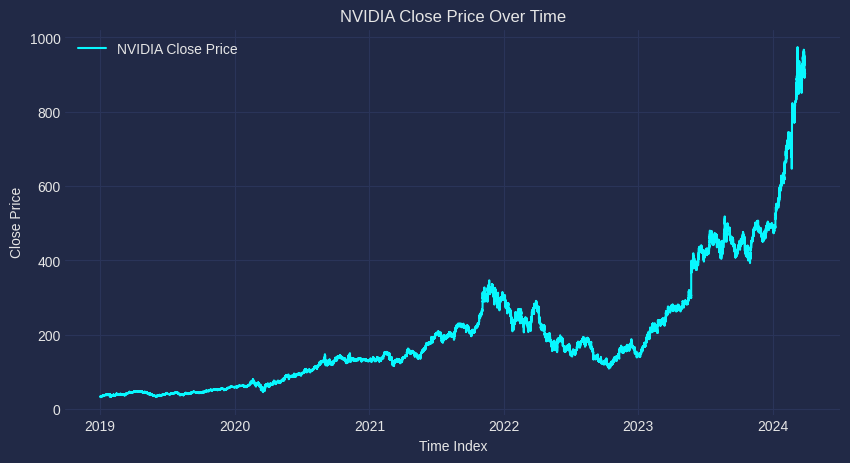

In [ ]:
# Check the Nvidia price distribution after dividend
plt.figure(figsize=(10, 5))

plt.plot(df['DateTime'], df['NVDA_Close'], label='NVIDIA Close Price')
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.title('NVIDIA Close Price Over Time')

plt.legend()
plt.show()

# RL Environment Set-up

In [ ]:
class StockData:
    def __init__(self, df, n_stocks=2):
        self.df = df
        self.n_stocks = n_stocks
        self.shape = self.get_state(0).shape

    def get_state(self, time_index):
        current_state = self.df.iloc[time_index][[
            'AMD_Open', 'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume', 'AMD_Google Trends',
            'NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume', 'NVDA_Google Trends',
            'S&P 500', 'NASDAQ-100', 'PHLX Semiconductor', 'Inflation Rate',
            'Federal Reserve Interest Rate', 'Consumer Confidence Index', 'Effective Federal Fund Rate',
            'Oil Prices', 'Gold Prices'
        ]]
        current_state['S&P 500'] *= 1e-2
        current_state['NASDAQ-100'] *= 1e-2
        current_state['PHLX Semiconductor'] *= 1e-2

        return current_state.values

    def get_sell_price(self, time_index):
        sell_price = np.array([
            self.df.iloc[time_index]['AMD_Open'],
            self.df.iloc[time_index]['NVDA_Open']
        ])
        return sell_price

    def get_buy_price(self, time_index):
        buy_price = np.array([
            self.df.iloc[time_index]['AMD_Close'],
            self.df.iloc[time_index]['NVDA_Close']
        ])
        return buy_price


In [ ]:
# Define ComplexTrader Environment
import gymnasium as gym
from gymnasium import spaces

class ComplexTrader(gym.Env):
    def __init__(self, states, initial_balance=1e6):
        super(ComplexTrader, self).__init__()

        self.states = states
        self.initial_balance = np.copy(np.array([initial_balance]))
        self.balance = np.array([initial_balance])

        self.previous_networth = self.initial_balance
        self.networth = self.initial_balance

        self.initial_shares = np.zeros(self.states.n_stocks)
        self.shares = np.zeros(self.states.n_stocks)

        self.time_index = 0

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.states.n_stocks,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.states.get_state(0).size + 2 * self.states.n_stocks,), dtype=np.float32)

        self.state = np.concatenate([self.states.get_state(0), self.balance, self.shares])

    def reset(self):
        self.balance = np.copy(self.initial_balance)
        self.networth = np.copy(self.initial_balance)
        self.shares = np.copy(self.initial_shares)
        self.state = np.concatenate([self.states.get_state(0), self.balance, self.shares])
        self.time_index = 0

        return self.state

    def step(self, action):
        balance_change, share_change = self.take_action(action)
        self.set_networth()

        epsilon = 1e-8  # small value to avoid division by zero
        reward = np.log(self.networth + epsilon) - np.log(self.previous_networth + epsilon)

        self.time_index += 1
        self.update_state()

        done = self.time_index >= len(self.states.df) - 1
        info = {'balance_change' : balance_change, 'share_change' : share_change}

        return self.state, reward, done, info

    def update_state(self):
        self.state = np.concatenate([self.states.get_state(self.time_index), self.balance, self.shares])

    def take_action(self, action):
        sell_price = self.states.get_sell_price(self.time_index)
        buy_price = self.states.get_buy_price(self.time_index)

        balance_change = np.zeros(self.states.n_stocks)
        share_change = np.zeros(self.states.n_stocks)

        for i in range(len(action)):
            action_value = action[i].item()
            if action_value < 0:  # sell
                sell_amount = min(self.shares[i], -action_value * self.shares[i]).item()
                share_change[i] = -sell_amount
                balance_change[i] = sell_amount * sell_price[i]
                self.balance += balance_change[i]

        for i in range(len(action)):
            action_value = action[i].item()
            if action_value >= 0:  # buy
                buy_amount = (min(self.balance, action_value * self.balance) / buy_price[i]).item()
                share_change[i] = buy_amount
                balance_change[i] = -buy_amount * buy_price[i]
                self.balance += balance_change[i]

        self.shares += share_change

        return balance_change, share_change

    def set_networth(self):
        self.previous_networth = self.networth
        self.networth = self.balance + np.sum(self.shares * self.states.get_sell_price(self.time_index))

    def render(self, mode='human', close=False):
        print(f'Time Index: {self.time_index}')
        print(f'Shares: {self.shares}')
        print(f'Balance: {self.balance}')
        print(f'Networth: {self.networth}')

In [ ]:
# Define SimpleTrader Environment
class SimpleTrader(gym.Env):
    def __init__(self, states, initial_balance=1e6):
        super(SimpleTrader, self).__init__()

        self.states = states
        self.initial_balance = np.array([initial_balance], dtype=np.float32)
        self.balance = np.array([initial_balance], dtype=np.float32)

        self.previous_networth = self.initial_balance
        self.networth = self.initial_balance

        self.initial_shares = np.zeros(self.states.n_stocks, dtype=np.float32)
        self.shares = np.zeros(self.states.n_stocks, dtype=np.float32)

        self.time_index = 0

        obs_shape = self.states.get_state(0).size + self.balance.size + self.shares.size
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_shape,), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([3] * self.states.n_stocks)

        self.state = np.concatenate([self.states.get_state(0).astype(np.float32), self.balance, self.shares])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = np.copy(self.initial_balance)
        self.networth = np.copy(self.initial_balance)
        self.shares = np.copy(self.initial_shares)
        self.state = np.concatenate([self.states.get_state(0).astype(np.float32), self.balance, self.shares])
        self.time_index = 0

        return self.state, {}

    def step(self, action):
        balance_change, share_change = self.take_action(action)
        self.set_networth()

        epsilon = 1e-8  # small value to avoid division by zero
        reward = np.log(self.networth + epsilon) - np.log(self.previous_networth + epsilon)
        reward = float(reward)

        self.time_index += 1
        self.update_state()

        done = self.time_index >= len(self.states.df) - 1
        truncated = False
        info = {'balance_change': balance_change, 'share_change': share_change}

        return self.state, reward, done, truncated, info

    def update_state(self):
        self.state = np.concatenate([self.states.get_state(self.time_index).astype(np.float32), self.balance, self.shares])

    def take_action(self, action):
        sell_price = self.states.get_sell_price(self.time_index).astype(np.float32)
        buy_price = self.states.get_buy_price(self.time_index).astype(np.float32)

        balance_change = np.zeros(self.states.n_stocks, dtype=np.float32)
        share_change = np.zeros(self.states.n_stocks, dtype=np.float32)

        for i in range(len(self.shares)):
            if action[i] == 0:  # buy
                amount_to_spend = 0.05 * self.balance[0]
                # Buy 5% of balance in shares
                shares_to_buy = amount_to_spend // buy_price[i]
                buy_cost = shares_to_buy * buy_price[i]
                if self.balance[0] - buy_cost >= 0:  # check if balance will remain non-negative
                    self.shares[i] += shares_to_buy
                    balance_change[i] -= buy_cost
                    self.balance[0] -= buy_cost  # deduct the cost from balance
            elif action[i] == 1:  # sell
                shares_to_sell = 0.05 * self.shares[i]
                # Sell 5% of shares held
                sell_income = shares_to_sell * sell_price[i]
                self.shares[i] -= shares_to_sell
                balance_change[i] += sell_income
                self.balance[0] += sell_income  # add the income to balance

        return balance_change, share_change

    def set_networth(self):
        self.previous_networth = self.networth
        self.networth = self.balance[0] + np.sum(self.shares * self.states.get_sell_price(self.time_index).astype(np.float32))

    def render(self, mode='human', close=False):
        print(f'Time Index: {self.time_index}')
        print(f'Shares: {self.shares}')
        print(f'Balance: {self.balance}')
        print(f'Networth: {self.networth}')

In [ ]:
# Test the ComplexTrader Environment
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Read the data
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/final_data.csv', parse_dates=['DateTime'])

# Initialise stock data
stock_data = StockData(df, n_stocks=2)

# Initialise the environment
env = ComplexTrader(stock_data)
state = env.reset()
print(f"Initial state: {state}")

done = False
steps = 0
max_steps = 5  # set the steps to 5 for example

while not done and steps < max_steps:
    action = env.action_space.sample()  # take a random action
    state, reward, done, info = env.step(action)
    print(f"Step: {steps}, State: {state}, Reward: {reward}, Action: {action}")
    env.render()
    steps += 1

Initial state: [18.09 18.09 18.0 18.0 2054.0 60 32.5 32.5 32.3825 32.3825 2226.0 87
 25.10030029296875 63.608701171875005 11.65300048828125 252.561 2.4 91.2
 2.4 46.540000915527344 1281.0 1000000.0 0.0 0.0]
Step: 0, State: [17.82 17.82 17.82 17.82 100.0 60 32.5 32.5 32.3825 32.3825 0.0 87
 25.10030029296875 63.608701171875005 11.65300048828125 252.561 2.4 91.2
 2.4 46.540000915527344 1281.0 441182.06453303446 14338.721831639608
 9286.52644167228], Reward: [0.00237882], Action: [0.258097   0.40533727]
Time Index: 1
Shares: [14338.72183164  9286.52644167]
Balance: [441182.06453303]
Networth: [1002381.65182174]
Step: 1, State: [18.0 18.15 17.93 17.93 1100.0 60 32.5 32.5 32.3825 32.3825 0.0 87
 25.10030029296875 63.608701171875005 11.65300048828125 252.561 2.4 91.2
 2.4 46.540000915527344 1281.0 74190.12670851301 31723.04890683689
 11053.012332029908], Reward: [-0.00366188], Action: [0.70217884 0.4353586 ]
Time Index: 2
Shares: [31723.04890684 11053.01233203]
Balance: [74190.12670851]
Netw

In [ ]:
# Test the SimpleTrader Environment
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialise stock data
stock_data = StockData(df, n_stocks=2)

# Initialise the environment
env = SimpleTrader(stock_data)
state, _ = env.reset()
print(f"Initial state: {state}")

done = False
steps = 0
max_steps = 5  # set the steps to 5 for example

while not done and steps < max_steps:
    action = env.action_space.sample()  # take a random action
    next_state, reward, done, truncated, info = env.step(action)
    print(f"Step: {steps}, State: {next_state}, Reward: {reward}, Action: {action}")
    env.render()
    state = next_state
    steps += 1

Initial state: [1.8090000e+01 1.8090000e+01 1.8000000e+01 1.8000000e+01 2.0540000e+03
 6.0000000e+01 3.2500000e+01 3.2500000e+01 3.2382500e+01 3.2382500e+01
 2.2260000e+03 8.7000000e+01 2.5100300e+01 6.3608700e+01 1.1653001e+01
 2.5256100e+02 2.4000001e+00 9.1199997e+01 2.4000001e+00 4.6540001e+01
 1.2810000e+03 1.0000000e+06 0.0000000e+00 0.0000000e+00]
Step: 0, State: [1.7820000e+01 1.7820000e+01 1.7820000e+01 1.7820000e+01 1.0000000e+02
 6.0000000e+01 3.2500000e+01 3.2500000e+01 3.2382500e+01 3.2382500e+01
 0.0000000e+00 8.7000000e+01 2.5100300e+01 6.3608700e+01 1.1653001e+01
 2.5256100e+02 2.4000001e+00 9.1199997e+01 2.4000001e+00 4.6540001e+01
 1.2810000e+03 1.0000000e+06 0.0000000e+00 0.0000000e+00], Reward: 0.0, Action: [1 1]
Time Index: 1
Shares: [0. 0.]
Balance: [1000000.]
Networth: 1000000.0
Step: 1, State: [1.8000000e+01 1.8150000e+01 1.7930000e+01 1.7930000e+01 1.1000000e+03
 6.0000000e+01 3.2500000e+01 3.2500000e+01 3.2382500e+01 3.2382500e+01
 0.0000000e+00 8.7000000e+01 

# RL Algorithms Testing and Hyperparameters Tunning

## Testing Data Preparation

In [ ]:
# Create a sample dataset for testing the models
np.random.seed(100)
df = pd.read_csv('/content/drive/MyDrive/Dissertation/Processed Data/final_data.csv', parse_dates=['DateTime'])

# Select 100 random indices while maintaining sequential order
random_indices = np.sort(np.random.choice(df.index, size=100, replace=False))

# Slice the DataFrame based on these sorted indices
sample_data = df.loc[random_indices].sort_values(by='DateTime')

# Check the sample data
print(sample_data)

                   DateTime  AMD_Open  AMD_High   AMD_Low  AMD_Close  \
102756  2019-03-14 12:36:00   23.1600   23.1800   23.1600    23.1600   
117430  2019-03-24 17:10:00   26.3900   26.3900   26.3900    26.3900   
127105  2019-03-31 10:25:00   25.5300   25.5300   25.5200    25.5300   
139287  2019-04-08 21:27:00   28.4700   28.5000   28.4700    28.4700   
170490  2019-04-30 13:30:00   27.2700   27.2700   27.2500    27.2550   
...                     ...       ...       ...       ...        ...   
2566739 2023-11-19 14:59:00  120.8900  120.8900  120.8900   120.8900   
2603473 2023-12-15 03:13:00  137.4500  137.4800  137.4500   137.4500   
2621189 2023-12-27 10:29:00  143.8500  144.1400  143.8400   144.0200   
2626640 2023-12-31 05:20:00  147.2799  147.2799  147.2799   147.2799   
2701631 2024-02-21 07:11:00  163.3800  163.4500  163.3000   163.4500   

         AMD_Volume  AMD_Google Trends  NVDA_Open  NVDA_High  NVDA_Low  ...  \
102756      44614.0                 54    42.1000    42.

## Policy Network

In [ ]:
# Define Policy Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * output_size)  # output alpha and beta parameters
        )

    def forward(self, x):
        x = self.network(x)
        alpha_beta = F.softplus(x) + 1e-3  # ensure alpha and beta are positive and non-zero
        return alpha_beta[:, :x.size(1)//2], alpha_beta[:, x.size(1)//2:]  # split into alpha and beta



def train_policy_gradient(env, policy_network, optimizer, num_episodes, exploratory_level, no_action_penalty):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            # Track actions, transactions and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            optimizer.zero_grad()
            reward_tensor = torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device)
            log_prob = action_dist.log_prob(action).sum()
            loss = -log_prob * reward_tensor
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
            optimizer.step()

            state = next_state
            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

        rewards.append(total_reward)
        if episode + 1 in [1, 1000, 2000, 3000]:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert lists to numpy arrays for further calculations
    networth_last_episode = np.array(networth_last_episode).flatten()

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Setting up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and transaction plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year
    ax2 = axes[0, 1]
    for i in [0, 999, 1999, 2999]:
        if i < num_episodes:
            ax2.plot(dates_per_episode[i], cumulative_rewards_per_episode[i], label=f'Episode {i + 1}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')

    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Hyperparameter Tuning for the Policy Network
from sklearn.model_selection import ParameterGrid

# Set the seed for reproducibility
seed = 1
set_seed(seed)

# Define a function to train and evaluate
def train_and_evaluate(env, policy_network, optimizer, num_episodes, exploratory_level):
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            next_state, reward, done, info = env.step(action_np)

            optimizer.zero_grad()
            reward_tensor = torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device)
            log_prob = action_dist.log_prob(action).sum()
            loss = -log_prob * reward_tensor
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
            optimizer.step()

            state = next_state
            total_reward += reward
            cumulative_reward += reward

        rewards.append(total_reward)

    return np.mean(rewards)

# Hyperparameter tuning with grid search
param_grid = {
    'hidden_size': [64, 128],
    'lr': [0.001, 0.0001],
    'exploratory_level': [0.1, 0.2]
}

best_params = None
best_reward = -np.inf
results = []

grid = ParameterGrid(param_grid)

# Run the function to check different set of parameters
stock_data = StockData(sample_data)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()

input_size = len(initial_state)
output_size = stock_data.n_stocks

for params in grid:
    hidden_size = params['hidden_size']
    lr = params['lr']
    exploratory_level = params['exploratory_level']

    policy_network = PolicyNetwork(input_size, hidden_size, output_size)
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=lr)

    avg_reward = train_and_evaluate(complex_trader_env, policy_network, policy_optimizer, num_episodes=100, exploratory_level=exploratory_level)
    results.append((params, avg_reward))

    print(f"Params: {params}, Average Reward: {avg_reward}")

    if avg_reward > best_reward:
        best_reward = avg_reward
        best_params = params

# Displaying the results
for params, reward in results:
    print(f"Params: {params}, Average Reward: {reward}")

print(f"Best Parameters: {best_params}, with the best Average Reward: {best_reward}")

Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.5918861587683781
Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.0001}, Average Reward: 1.5135655310635099
Params: {'exploratory_level': 0.1, 'hidden_size': 128, 'lr': 0.001}, Average Reward: 0.8341320855691278
Params: {'exploratory_level': 0.1, 'hidden_size': 128, 'lr': 0.0001}, Average Reward: 1.6094428336735376
Params: {'exploratory_level': 0.2, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.638963371372486
Params: {'exploratory_level': 0.2, 'hidden_size': 64, 'lr': 0.0001}, Average Reward: 1.60303042213948
Params: {'exploratory_level': 0.2, 'hidden_size': 128, 'lr': 0.001}, Average Reward: 1.5349741899239142
Params: {'exploratory_level': 0.2, 'hidden_size': 128, 'lr': 0.0001}, Average Reward: 1.5965563678147086
Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.5918861587683781
Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.0001},

Training Policy Gradient with ComplexTrader...
Episode 1: Total Reward: [2.00633385], Balance: [3563668.85787271], Net Worth: [7436005.78468759], Shares (AMD: 20194.4911694185, Nvidia: 1819.8465791936114)
Episode 1000: Total Reward: [1.80676033], Balance: [3.63127745e-11], Net Worth: [6090683.60461609], Shares (AMD: 18009.780277254813, Nvidia: 6966.980681580606)
Episode 2000: Total Reward: [1.94013585], Balance: [3.43396007e-63], Net Worth: [6959696.3830828], Shares (AMD: 45603.3497336327, Nvidia: 492.8867166126633)
Episode 3000: Total Reward: [1.81999395], Balance: [3516707.63257208], Net Worth: [6171821.12378077], Shares (AMD: 18027.570165012396, Nvidia: 0.029908941588767012)
Initial Net Worth: 1000000
Final Net Worth: 6171821.123780767
Net Worth Change: 5171821.123780767
Return Percentage Calculation: 517.1821123780767
Last Episode Return%: 517.18%
Last Episode Sharpe Ratio: 4.36
Last Episode Maximum Drawdown: 1482637.79
Last Episode Hit Ratio: 0.59


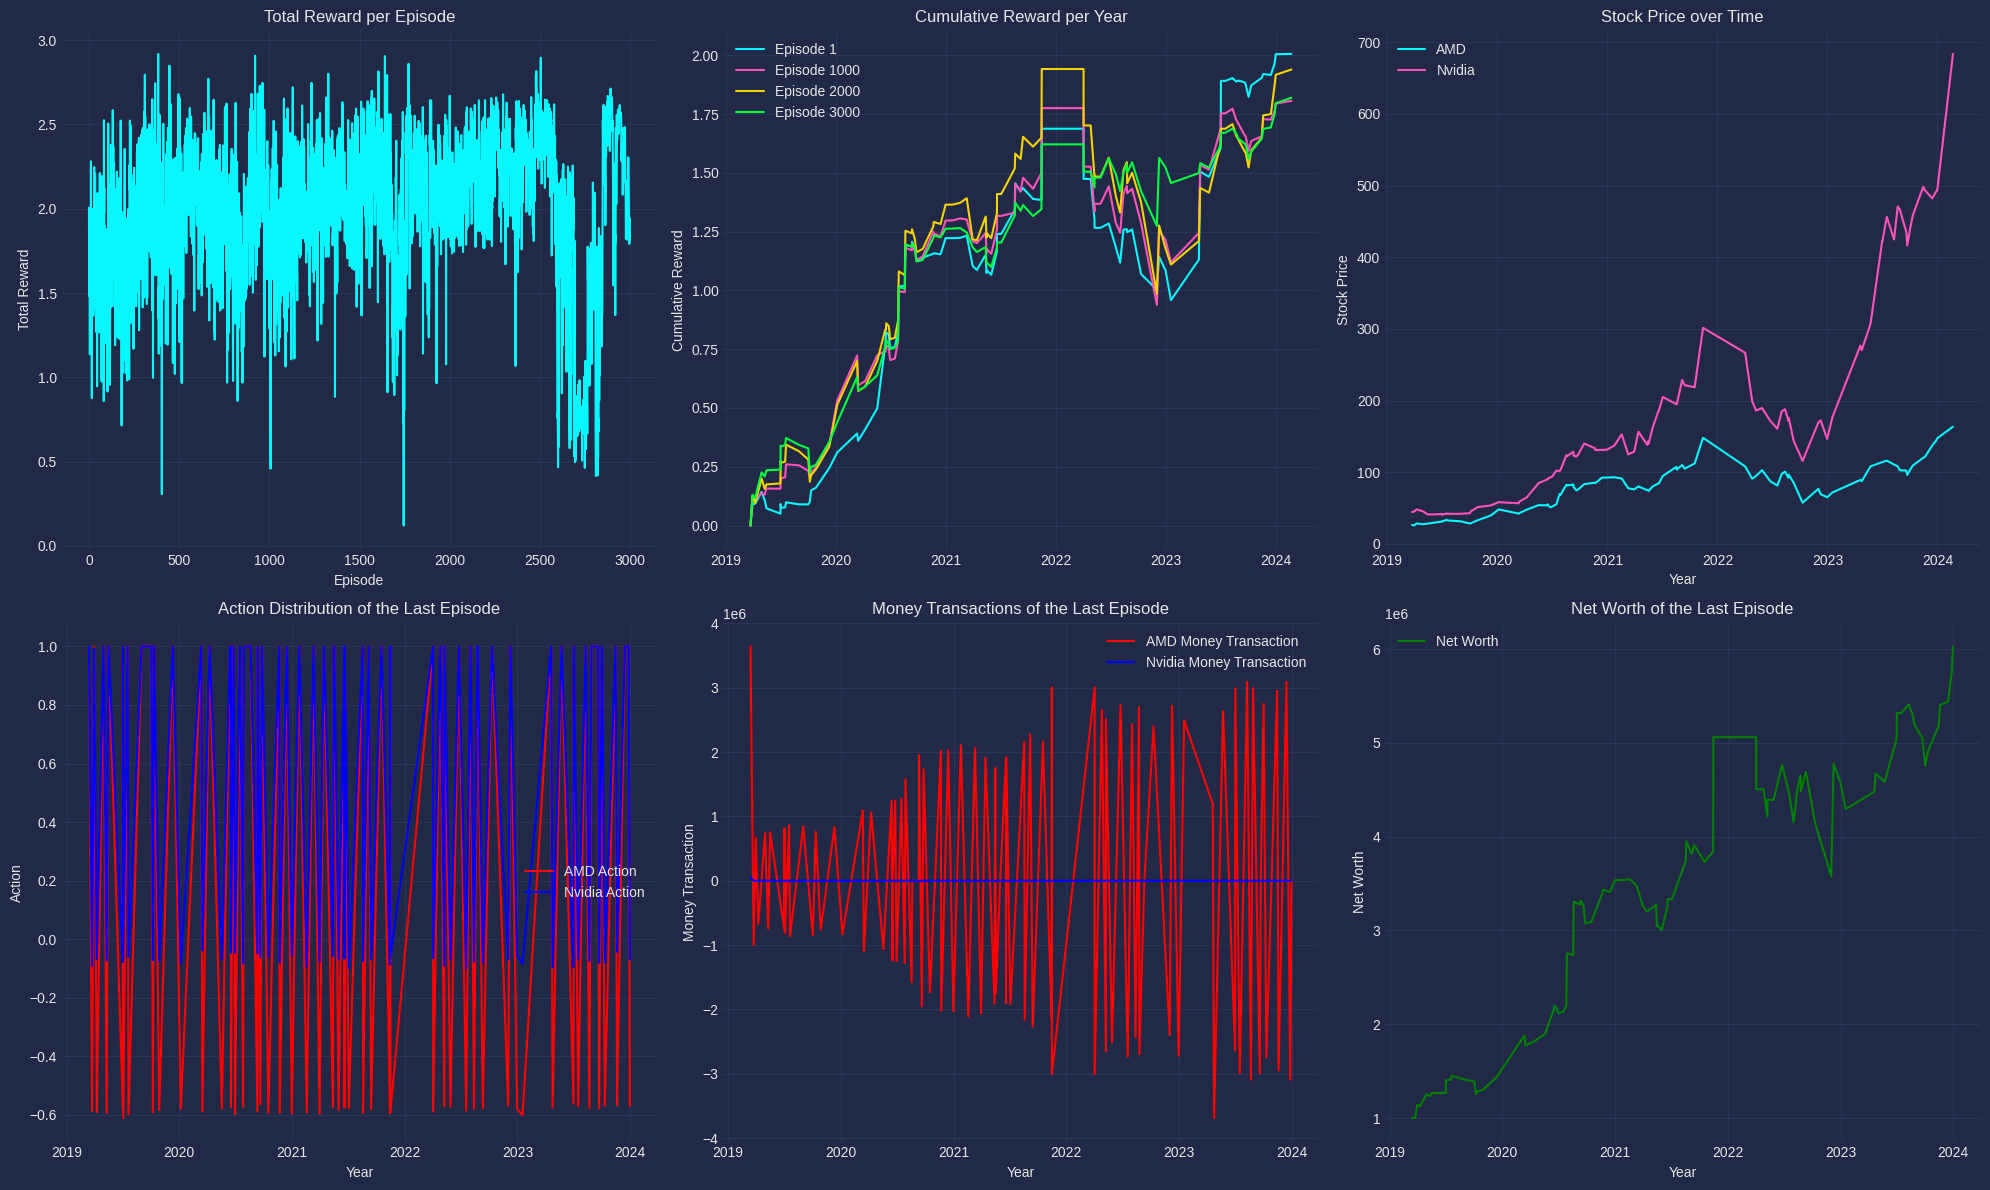

In [ ]:
# Testing Policy Network with the best parameters

# Set the seed for reproducibility
seed = 11
set_seed(seed)

hidden_size = best_params['hidden_size']
lr = best_params['lr']
exploratory_level = best_params['exploratory_level']

output_size = stock_data.n_stocks

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=lr)

print("Training Policy Gradient with ComplexTrader...")
train_policy_gradient(complex_trader_env, policy_network, policy_optimizer, num_episodes=3000, exploratory_level=exploratory_level, no_action_penalty=1)

## Policy Network with Baseline

In [ ]:
# Training process of Policy Network with baseline and exploratory level

# Define Value Network
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.network(x)

def train_policy_gradient_with_baseline(env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes, exploratory_level, no_action_penalty):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0
        episode_states = []
        episode_rewards = []
        episode_actions = []

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            # Track actions, transactions, and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

            # Save the state, reward, and action
            episode_states.append(state_tensor)
            episode_rewards.append(torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device))
            episode_actions.append(action_dist.log_prob(action).sum().to(device))

        rewards.append(total_reward)
        if episode + 1 in [1, 1000, 2000, 3000]:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

        # Compute the value targets and advantages
        episode_states = torch.cat(episode_states)
        episode_rewards = torch.cat(episode_rewards)
        value_estimates = value_network(episode_states)
        advantages = episode_rewards - value_estimates.detach()

        # Update the policy network using the advantages
        policy_loss = -(torch.stack(episode_actions) * advantages).mean()
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Update the value network
        value_loss = F.mse_loss(value_estimates, episode_rewards)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert lists to numpy arrays for further calculations
    networth_last_episode = np.array(networth_last_episode).flatten()

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Setting up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and transaction plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year
    ax2 = axes[0, 1]
    for i in [0, 999, 1999, 2999]:
        if i < num_episodes:
            ax2.plot(dates_per_episode[i], cumulative_rewards_per_episode[i], label=f'Episode {i + 1}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')

    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()


# Set up the environment for training Policy Network with Baseline using the sample data
stock_data = StockData(sample_data)

complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()
print(f"Initial state shape: {initial_state.shape}")

input_size = len(initial_state)
print(f"Input size to the network: {input_size}")


Initial state shape: (24,)
Input size to the network: 24


In [ ]:
# Hyperparameter Tuning for the Policy Network with Baseline

# Set the seed for reproducibility
seed = 2
set_seed(seed)

# Define a function to train and evaluate
def train_and_evaluate(env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes, exploratory_level):
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        episode_states = []
        episode_rewards = []
        episode_actions = []

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            next_state, reward, done, _ = env.step(action_np)

            total_reward += reward

            # Save the state, reward, and action
            episode_states.append(state_tensor)
            episode_rewards.append(torch.tensor(reward, dtype=torch.float32).unsqueeze(0))
            episode_actions.append(action_dist.log_prob(action).sum())

            state = next_state

        rewards.append(total_reward)

        # Compute the value targets and advantages
        episode_states = torch.cat(episode_states)
        episode_rewards = torch.cat(episode_rewards)
        value_estimates = value_network(episode_states)
        advantages = episode_rewards - value_estimates.detach()

        # Update the policy network using the advantages
        policy_loss = -(torch.stack(episode_actions) * advantages).mean()
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Update the value network
        value_loss = F.mse_loss(value_estimates, episode_rewards)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    return np.mean(rewards)

# Hyperparameter tuning with grid search
from sklearn.model_selection import ParameterGrid
warnings.filterwarnings("ignore", category=DeprecationWarning)

param_grid = {
    'hidden_size': [64, 128],
    'lr': [0.001, 0.0001],
    'exploratory_level': [0.1, 0.2]
}

best_params = None
best_reward = -np.inf
results = []

grid = ParameterGrid(param_grid)

# Run the function to check different set of parameters
stock_data = StockData(sample_data)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()

input_size = len(initial_state)
output_size = stock_data.n_stocks

for params in grid:
    hidden_size = params['hidden_size']
    lr = params['lr']
    exploratory_level = params['exploratory_level']

    policy_network = PolicyNetwork(input_size, hidden_size, output_size)
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=lr)

    value_network = ValueNetwork(input_size, hidden_size)
    value_optimizer = optim.Adam(value_network.parameters(), lr=lr)

    avg_reward = train_and_evaluate(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes=100, exploratory_level=exploratory_level)
    results.append((params, avg_reward))

    print(f"Params: {params}, Average Reward: {avg_reward}")

    if avg_reward > best_reward:
        best_reward = avg_reward
        best_params = params

# Displaying the results
for params, reward in results:
    print(f"Params: {params}, Average Reward: {reward}")

print(f"Best Parameters: {best_params}, with the best Average Reward: {best_reward}")


Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.655609282995915
Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.0001}, Average Reward: 1.5340052090608995
Params: {'exploratory_level': 0.1, 'hidden_size': 128, 'lr': 0.001}, Average Reward: 1.5674009491224181
Params: {'exploratory_level': 0.1, 'hidden_size': 128, 'lr': 0.0001}, Average Reward: 1.5962858383713938
Params: {'exploratory_level': 0.2, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.5574112889446345
Params: {'exploratory_level': 0.2, 'hidden_size': 64, 'lr': 0.0001}, Average Reward: 1.5726450639462015
Params: {'exploratory_level': 0.2, 'hidden_size': 128, 'lr': 0.001}, Average Reward: 1.380096846574486
Params: {'exploratory_level': 0.2, 'hidden_size': 128, 'lr': 0.0001}, Average Reward: 1.6546602205971797
Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.655609282995915
Params: {'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.0001},

Training Policy Gradient with Baseline and ComplexTrader...
Episode 1: Total Reward: [1.1958384], Balance: [3184843.74003208], Net Worth: [3306328.63655915], Shares (AMD: 4.667137620169502, Nvidia: 244.77714481274108)
Episode 1000: Total Reward: [2.40164017], Balance: [1.21814538e-17], Net Worth: [11041271.10803332], Shares (AMD: 3.2740388255557313e-19, Nvidia: 22373.396368861842)
Episode 2000: Total Reward: [2.46180379], Balance: [3.58945169e-27], Net Worth: [11725943.56652955], Shares (AMD: 1.133173698449833e-24, Nvidia: 23760.77723714194)
Episode 3000: Total Reward: [2.45897277], Balance: [4.6642207e-12], Net Worth: [11692794.19002344], Shares (AMD: 3.688873001863128, Nvidia: 23692.504342809756)
Initial Net Worth: 1000000
Final Net Worth: 11692794.190023443
Net Worth Change: 10692794.190023443
Return Percentage Calculation: 1069.2794190023442
Last Episode Return%: 1069.28%
Last Episode Sharpe Ratio: 4.13
Last Episode Maximum Drawdown: 4396747.98
Last Episode Hit Ratio: 0.59


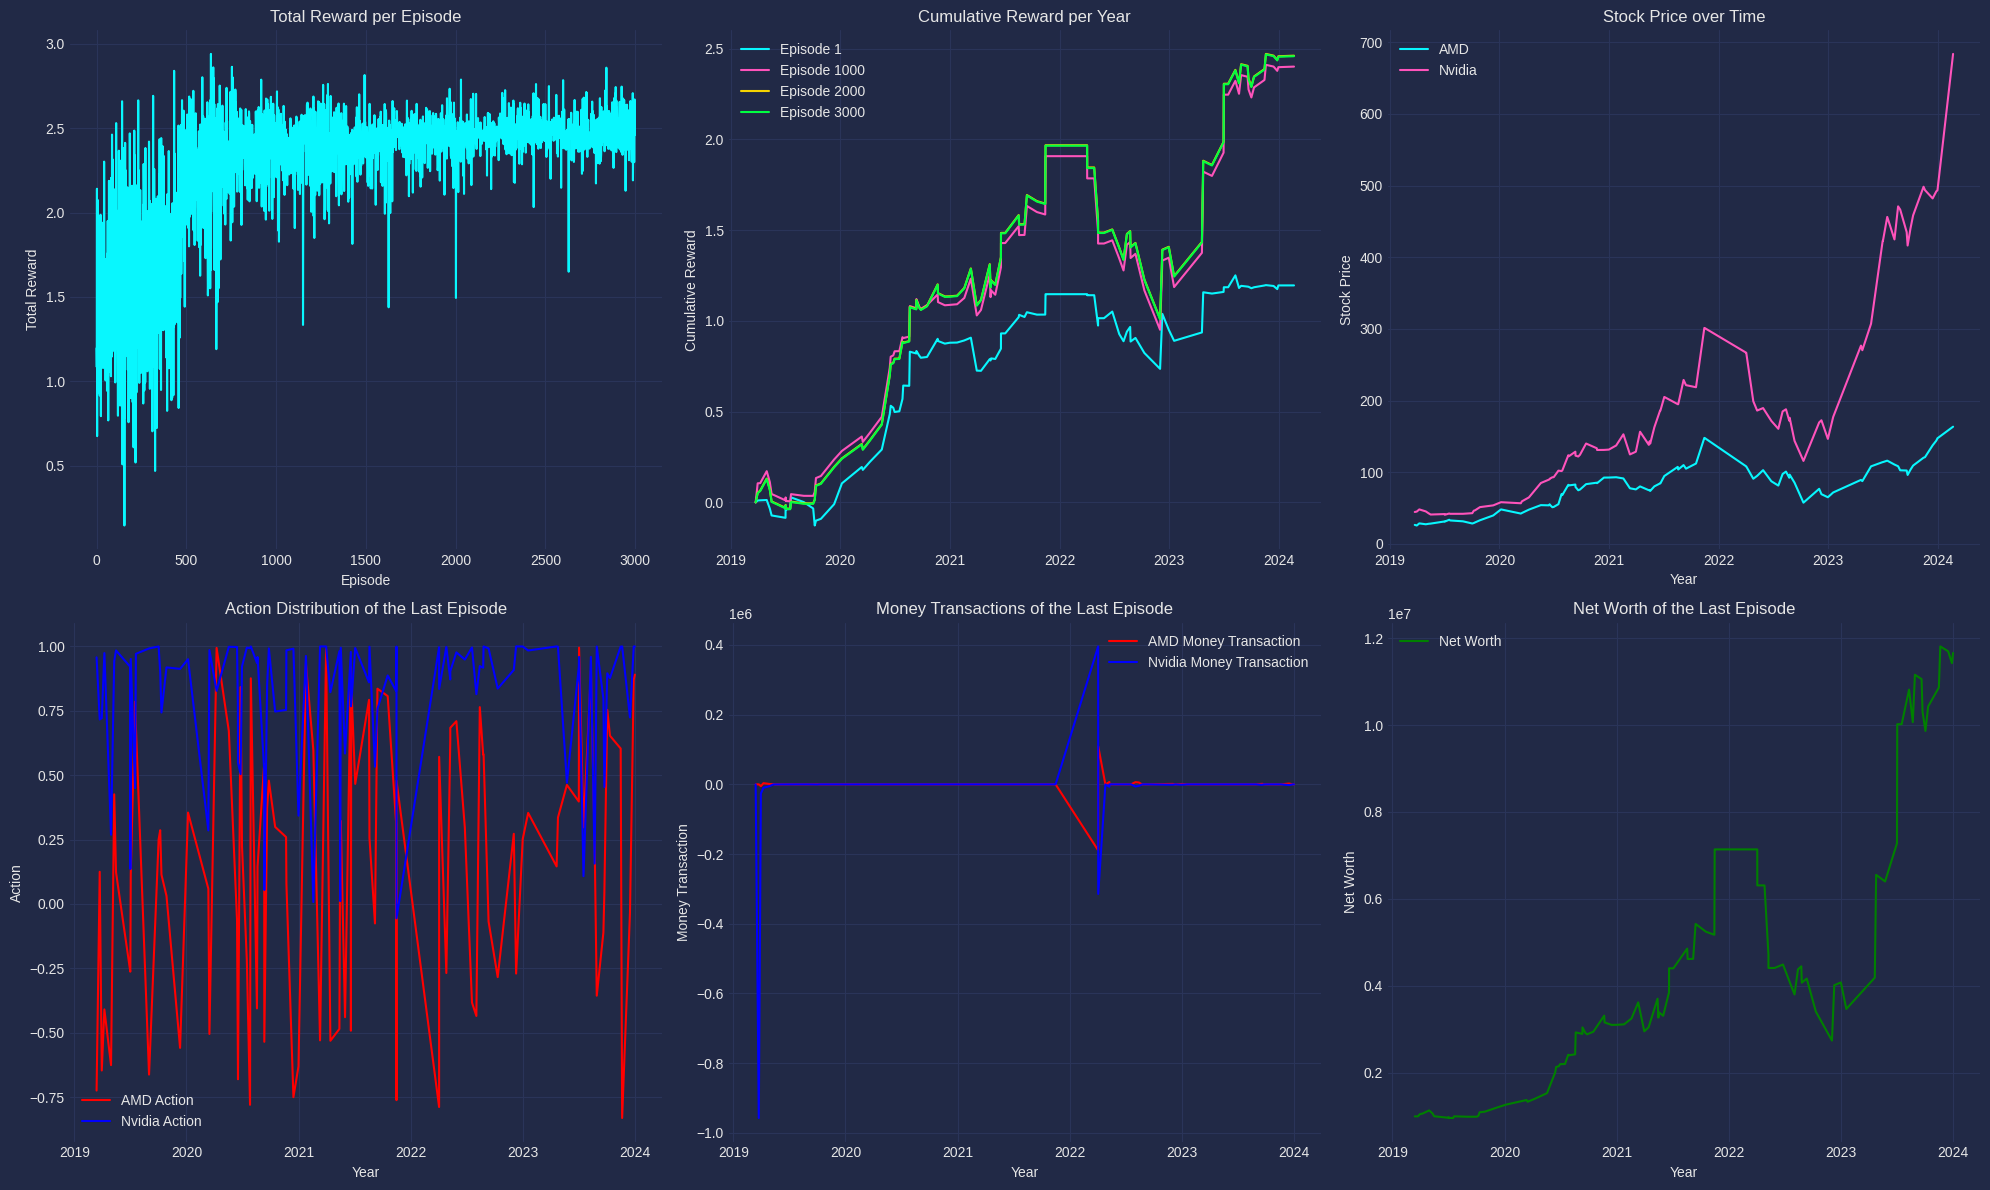

In [ ]:
# Testing Policy Network with Baseline with the best parameters

# Set the seed for reproducibility
seed = 22
set_seed(seed)

hidden_size = best_params['hidden_size']
lr = best_params['lr']
exploratory_level = best_params['exploratory_level']

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=lr)

value_network = ValueNetwork(input_size, hidden_size)
value_optimizer = optim.Adam(value_network.parameters(), lr=lr)

print("Training Policy Gradient with Baseline and ComplexTrader...")
train_policy_gradient_with_baseline(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes=3000, exploratory_level=exploratory_level, no_action_penalty=1)


## Actor-Critic with Epsilon-Greedy

In [ ]:
# Define Actor-Critic with Epsilon-Greedy

# Actor (Policy Network): Outputs actions given the current state.
# Critic (Value Network): Evaluates the state-action pairs.

def train_actor_critic_with_epsilon_greedy(env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes, exploratory_level, epsilon_start, epsilon_end, epsilon_decay, no_action_penalty=1):
    policy_network.to(device)
    value_network.to(device)
    epsilon = epsilon_start
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            if random.random() < epsilon:
                action_np = env.action_space.sample()
                log_prob = torch.tensor(0.0, requires_grad=True)  # No log probability for random action
            else:
                alpha, beta = policy_network(state_tensor)
                action_dist = torch.distributions.Beta(alpha, beta)
                if random.random() < prob_rand_action:
                    action = torch.rand(2)
                    action_np = 2 * action.cpu().numpy() - 1
                else:
                    action = action_dist.sample()
                    action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                    action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]
                log_prob = action_dist.log_prob(action).sum()

            # Track actions, transactions, and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            next_state = np.array(next_state, dtype=np.float32)

            value = value_network(state_tensor)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            next_value = value_network(next_state_tensor)

            reward_tensor = torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device)
            advantage = reward_tensor + (1 - done) * next_value - value

            policy_optimizer.zero_grad()
            policy_loss = -log_prob * advantage.detach()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
            policy_optimizer.step()

            value_optimizer.zero_grad()
            value_loss = advantage.pow(2).mean()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_network.parameters(), max_norm=1.0)
            value_optimizer.step()

            state = next_state
            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards.append(total_reward)
        if episode + 1 in [1, 1000, 2000, 3000]:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert lists to numpy arrays for further calculations
    networth_last_episode = np.array(networth_last_episode).flatten()

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Set up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and money transactions plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year
    ax2 = axes[0, 1]
    for i in [0, 999, 1999, 2999]:
        if i < num_episodes:
            ax2.plot(dates_per_episode[i], cumulative_rewards_per_episode[i], label=f'Episode {i + 1}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')  # Using the dates from the first episode for x-axis
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')
    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Hyperparameter Tuning for Actor-Critic with Epsilon-Greedy

# Set the seed for reproducibility
seed = 3
set_seed(seed)

# Define a function to train and evaluate
def train_and_evaluate_actor_critic(env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes, exploratory_level, epsilon_start, epsilon_end, epsilon_decay):
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            if random.random() < epsilon_start:
                action_np = env.action_space.sample()
                log_prob = torch.tensor(0.0, requires_grad=True)  # No log probability for random action
            else:
                alpha, beta = policy_network(state_tensor)
                action_dist = torch.distributions.Beta(alpha, beta)
                if random.random() < prob_rand_action:
                    action = torch.rand(2)
                    action_np = 2 * action.cpu().numpy() - 1
                else:
                    action = action_dist.sample()
                    action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                    action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]
                log_prob = action_dist.log_prob(action).sum()

            next_state, reward, done, _ = env.step(action_np)

            next_state = np.array(next_state, dtype=np.float32)

            value = value_network(state_tensor)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            next_value = value_network(next_state_tensor)

            reward_tensor = torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device)
            advantage = reward_tensor + (1 - done) * next_value - value

            policy_optimizer.zero_grad()
            policy_loss = -log_prob * advantage.detach()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
            policy_optimizer.step()

            value_optimizer.zero_grad()
            value_loss = advantage.pow(2).mean()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_network.parameters(), max_norm=1.0)
            value_optimizer.step()

            state = next_state
            total_reward += reward

        epsilon_start = max(epsilon_end, epsilon_start * epsilon_decay)
        rewards.append(total_reward)

    return np.mean(rewards)

# Hyperparameter tuning with grid search
from sklearn.model_selection import ParameterGrid
warnings.filterwarnings("ignore", category=DeprecationWarning)

param_grid = {
    'hidden_size': [64, 128],
    'lr': [0.001, 0.0001],
    'exploratory_level': [0.1, 0.2],
    'epsilon_start': [1.0],
    'epsilon_end': [0.1],
    'epsilon_decay': [0.995, 0.99]
}

best_params = None
best_reward = -np.inf
results = []

grid = ParameterGrid(param_grid)

# Run the function to check different set of parameters
stock_data = StockData(sample_data)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()

input_size = len(initial_state)
output_size = stock_data.n_stocks

for params in grid:
    hidden_size = params['hidden_size']
    lr = params['lr']
    exploratory_level = params['exploratory_level']
    epsilon_start = params['epsilon_start']
    epsilon_end = params['epsilon_end']
    epsilon_decay = params['epsilon_decay']

    policy_network = PolicyNetwork(input_size, hidden_size, output_size)
    value_network = ValueNetwork(input_size, hidden_size)
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=lr)
    value_optimizer = optim.Adam(value_network.parameters(), lr=lr)

    avg_reward = train_and_evaluate_actor_critic(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes=100, exploratory_level=exploratory_level, epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)
    results.append((params, avg_reward))

    print(f"Params: {params}, Average Reward: {avg_reward}")

    if avg_reward > best_reward:
        best_reward = avg_reward
        best_params = params

# Displaying the results
for params, reward in results:
    print(f"Params: {params}, Average Reward: {reward}")

print(f"Best Parameters: {best_params}, with the best Average Reward: {best_reward}")


Params: {'epsilon_decay': 0.995, 'epsilon_end': 0.1, 'epsilon_start': 1.0, 'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.5072546818882333
Params: {'epsilon_decay': 0.995, 'epsilon_end': 0.1, 'epsilon_start': 1.0, 'exploratory_level': 0.1, 'hidden_size': 64, 'lr': 0.0001}, Average Reward: 1.540386334017565
Params: {'epsilon_decay': 0.995, 'epsilon_end': 0.1, 'epsilon_start': 1.0, 'exploratory_level': 0.1, 'hidden_size': 128, 'lr': 0.001}, Average Reward: 1.5208387963919596
Params: {'epsilon_decay': 0.995, 'epsilon_end': 0.1, 'epsilon_start': 1.0, 'exploratory_level': 0.1, 'hidden_size': 128, 'lr': 0.0001}, Average Reward: 1.5890538411570931
Params: {'epsilon_decay': 0.995, 'epsilon_end': 0.1, 'epsilon_start': 1.0, 'exploratory_level': 0.2, 'hidden_size': 64, 'lr': 0.001}, Average Reward: 1.7229840423760532
Params: {'epsilon_decay': 0.995, 'epsilon_end': 0.1, 'epsilon_start': 1.0, 'exploratory_level': 0.2, 'hidden_size': 64, 'lr': 0.0001}, Average Reward: 1

Training Actor-Critic with Epsilon-Greedy...
Episode 1: Total Reward: [1.39979777], Balance: [785063.64706388], Net Worth: [4054379.97389416], Shares (AMD: 15577.00156039252, Nvidia: 1975.9616914201108)
Episode 1000: Total Reward: [2.01650713], Balance: [5.00819492e-141], Net Worth: [7512040.46443478], Shares (AMD: 46853.09670632015, Nvidia: 1239.1510979485722)
Episode 2000: Total Reward: [1.85160176], Balance: [-1.93e-322], Net Worth: [6370014.56411781], Shares (AMD: 42285.603475026495, Nvidia: 288.1359936702294)
Episode 3000: Total Reward: [1.89967813], Balance: [1.83e-322], Net Worth: [6683742.77687102], Shares (AMD: 42456.670589082954, Nvidia: 872.8036031974541)
Initial Net Worth: 1000000
Final Net Worth: 6683742.776871023
Net Worth Change: 5683742.776871023
Return Percentage Calculation: 568.3742776871023
Last Episode Return%: 568.37%
Last Episode Sharpe Ratio: 3.79
Last Episode Maximum Drawdown: 3994491.76
Last Episode Hit Ratio: 0.58


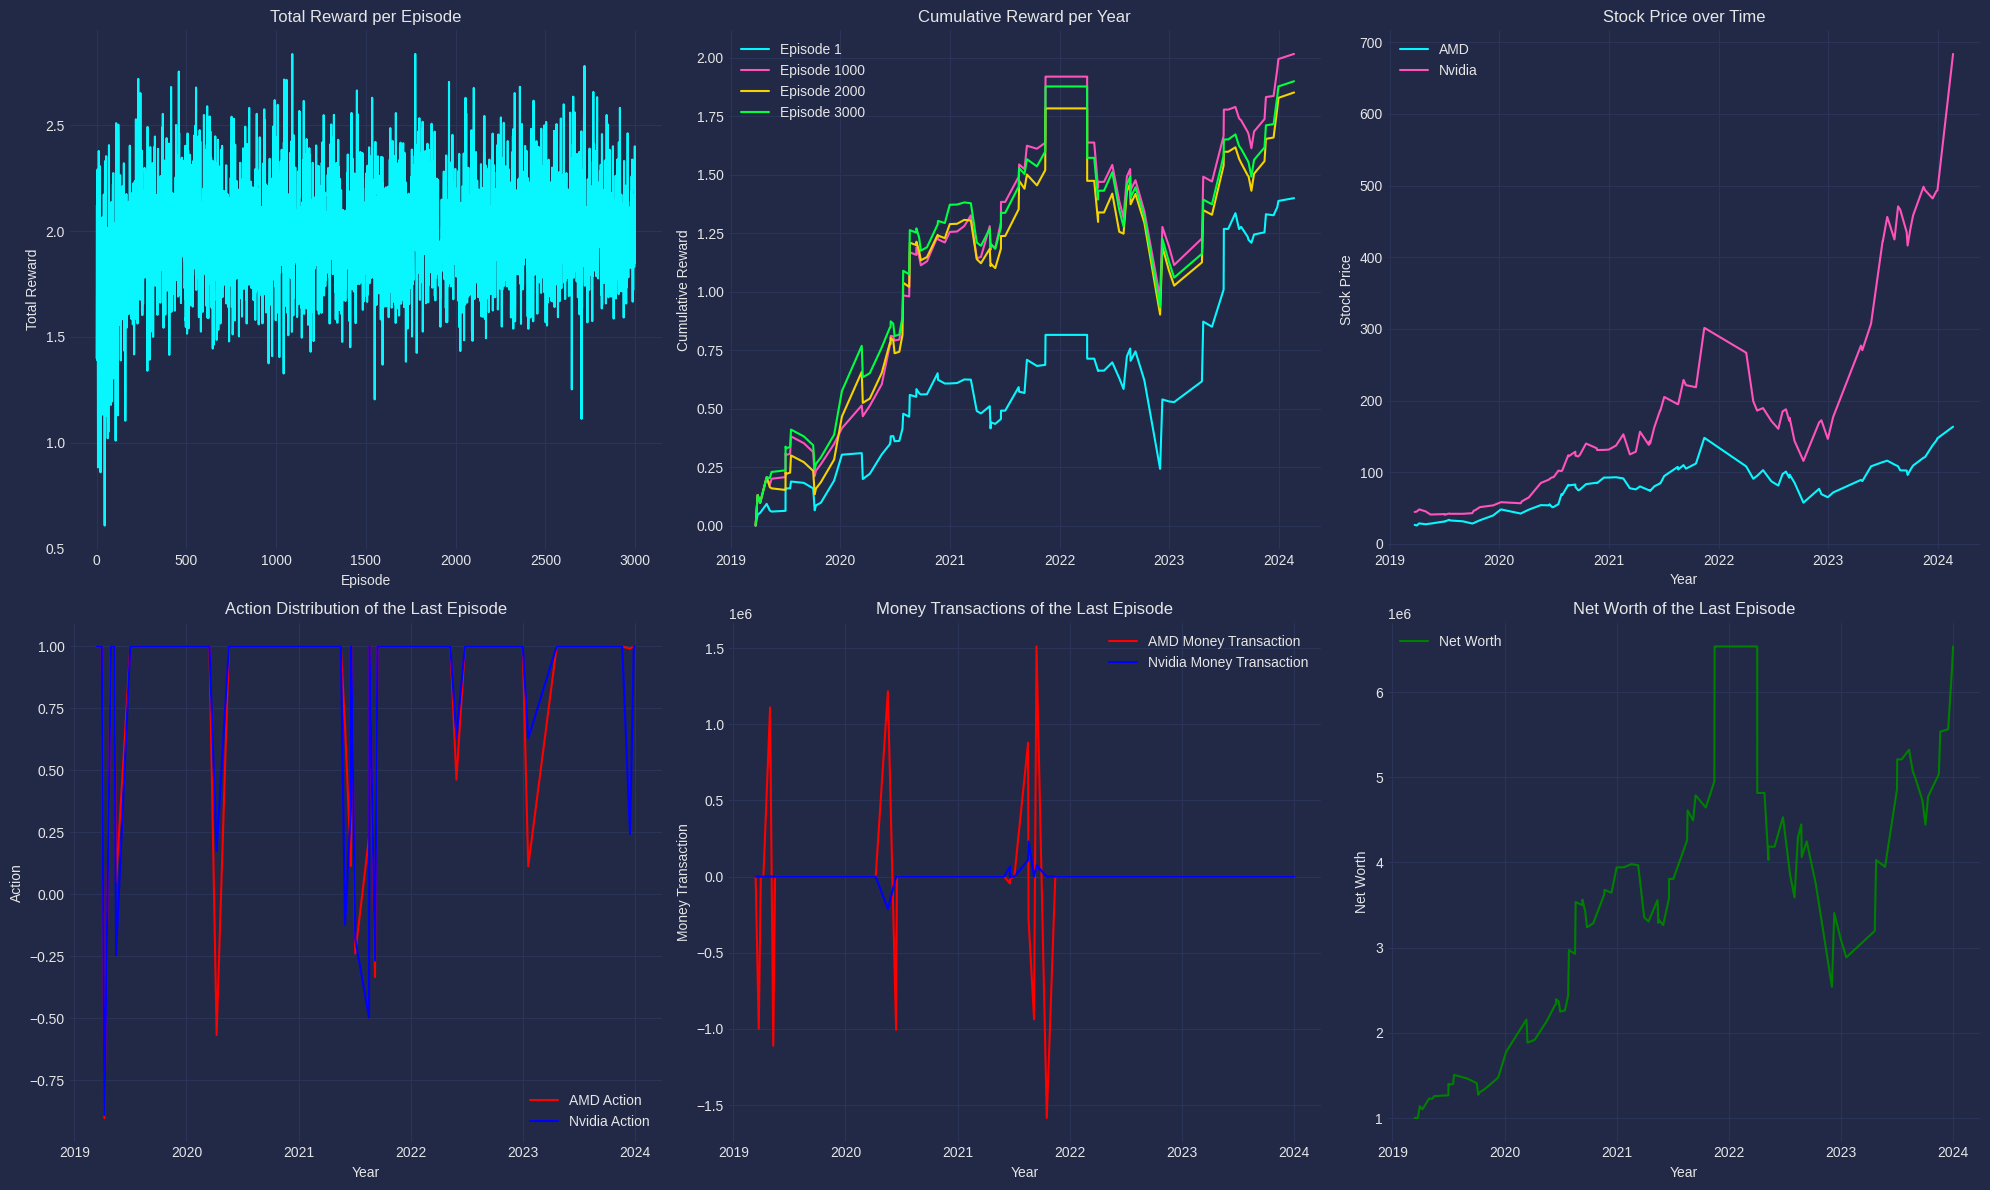

In [ ]:
# Testing Actor-Critic with the best parameters

# Set the seed for reproducibility
seed = 33
set_seed(seed)

hidden_size = best_params['hidden_size']
lr = best_params['lr']
exploratory_level = best_params['exploratory_level']
epsilon_start = best_params['epsilon_start']
epsilon_end = best_params['epsilon_end']
epsilon_decay = best_params['epsilon_decay']

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
value_network = ValueNetwork(input_size, hidden_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=lr)
value_optimizer = optim.Adam(value_network.parameters(), lr=lr)

print("Training Actor-Critic with Epsilon-Greedy...")
train_actor_critic_with_epsilon_greedy(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes=3000, exploratory_level=exploratory_level, epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay, no_action_penalty=1)


## Deep Q-learning

In [ ]:
# Define Q-learning Training and Plotting Function
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

# Training function
def train_and_plot(env, num_episodes, steps_per_episode, model):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode_amd = []
    actions_last_episode_nvda = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start

    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        total_reward = 0
        cumulative_reward = 0

        for step in range(steps_per_episode):
            action, _states = model.predict(state, deterministic=False)

            # Record information after taking the action
            cumulative_rewards_per_episode[episode].append(cumulative_reward)
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])
            if episode == num_episodes - 1:
                actions_last_episode_amd.append(action[0])
                actions_last_episode_nvda.append(action[1])
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(float(env.networth))
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            # Take the action
            next_state, reward, done, truncated, info = env.step(action)

            # Update state and rewards
            state = next_state
            total_reward += reward
            cumulative_reward += reward

            if done:
                break

        rewards.append(total_reward)
        if episode + 1 in [1, 1000, 2000, 3000]:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert actions of the last episode to numpy array
    actions_array_amd = np.array(actions_last_episode_amd)
    actions_array_nvda = np.array(actions_last_episode_nvda)

    # Ensure networth_last_episode contains only floats
    networth_last_episode = np.array([float(x) for x in networth_last_episode])

    # Convert money transactions to numpy array
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array_amd), len(actions_array_nvda), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array_amd = actions_array_amd[:min_length]
    actions_array_nvda = actions_array_nvda[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Setting up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and transaction plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year
    ax2 = axes[0, 1]
    for i in [0, 999, 1999, 2999]:
        if i < num_episodes:
            ax2.plot(dates_per_episode[i], cumulative_rewards_per_episode[i], label=f'Episode {i + 1}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution for AMD and Nvidia
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array_amd, 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array_nvda, 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')

    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.show()


In [ ]:
# Grid Search for Q-learning Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set the seed for reproducibility
seed = 4
set_seed(seed)

# Function to train and evaluate
def train_and_evaluate(env, model_class, num_episodes, steps_per_episode, **model_params):
    model = model_class('MlpPolicy', env, verbose=0, **model_params)
    total_timesteps = num_episodes * steps_per_episode
    model.learn(total_timesteps=total_timesteps)

    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        total_reward = 0

        for step in range(steps_per_episode):
            action, _states = model.predict(state, deterministic=False)
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            total_reward += reward
            if done:
                break

        rewards.append(total_reward)

    avg_reward = np.mean(rewards)
    return avg_reward

# Hyperparameter grid
param_grid = {
    'n_steps': [1024, 2048],
    'batch_size': [32, 64],
    'learning_rate': [3e-4, 1e-4]
}

best_params = None
best_reward = -np.inf
results = []

grid = ParameterGrid(param_grid)

# Initialize stock data
stock_data = StockData(sample_data, n_stocks=2)
env = SimpleTrader(stock_data)

# Perform grid search
for params in grid:
    avg_reward = train_and_evaluate(env, PPO, num_episodes=100, steps_per_episode=100, **params)
    results.append((params, avg_reward))
    print(f"Params: {params}, Average Reward: {avg_reward}")

    if avg_reward > best_reward:
        best_reward = avg_reward
        best_params = params

# Display results
for params, reward in results:
    print(f"Params: {params}, Average Reward: {reward}")

print(f"Best Parameters: {best_params}, with the best Average Reward: {best_reward}")


Params: {'batch_size': 32, 'learning_rate': 0.0003, 'n_steps': 1024}, Average Reward: 1.59650827811333
Params: {'batch_size': 32, 'learning_rate': 0.0003, 'n_steps': 2048}, Average Reward: 1.6143513127178606
Params: {'batch_size': 32, 'learning_rate': 0.0001, 'n_steps': 1024}, Average Reward: 1.521114072060193
Params: {'batch_size': 32, 'learning_rate': 0.0001, 'n_steps': 2048}, Average Reward: 1.634829771568287
Params: {'batch_size': 64, 'learning_rate': 0.0003, 'n_steps': 1024}, Average Reward: 1.596827302375054
Params: {'batch_size': 64, 'learning_rate': 0.0003, 'n_steps': 2048}, Average Reward: 1.5197967009066633
Params: {'batch_size': 64, 'learning_rate': 0.0001, 'n_steps': 1024}, Average Reward: 1.625834583368469
Params: {'batch_size': 64, 'learning_rate': 0.0001, 'n_steps': 2048}, Average Reward: 1.6236409506316587
Params: {'batch_size': 32, 'learning_rate': 0.0003, 'n_steps': 1024}, Average Reward: 1.59650827811333
Params: {'batch_size': 32, 'learning_rate': 0.0003, 'n_steps': 

Episode 1: Total Reward: 2.039856640916092, Balance: [292715.7], Net Worth: 7689505.0, Shares (AMD: 6292.49169921875, Nvidia: 13110.5)
Episode 1000: Total Reward: 1.9046214533851025, Balance: [139650.3], Net Worth: 6716864.5, Shares (AMD: 9867.89453125, Nvidia: 10382.71875)
Episode 2000: Total Reward: 1.845354105163251, Balance: [248729.94], Net Worth: 6330341.0, Shares (AMD: 9765.185546875, Nvidia: 9409.109375)
Episode 3000: Total Reward: 1.9341520184843635, Balance: [191300.2], Net Worth: 6918173.5, Shares (AMD: 12330.328125, Nvidia: 9951.091796875)
Initial Net Worth: 1000000
Final Net Worth: 6918173.5
Net Worth Change: 5918173.5
Return Percentage Calculation: 591.81735
Last Episode Return%: 591.82%
Last Episode Sharpe Ratio: 3.83
Last Episode Maximum Drawdown: 3031951.12
Last Episode Hit Ratio: 0.59


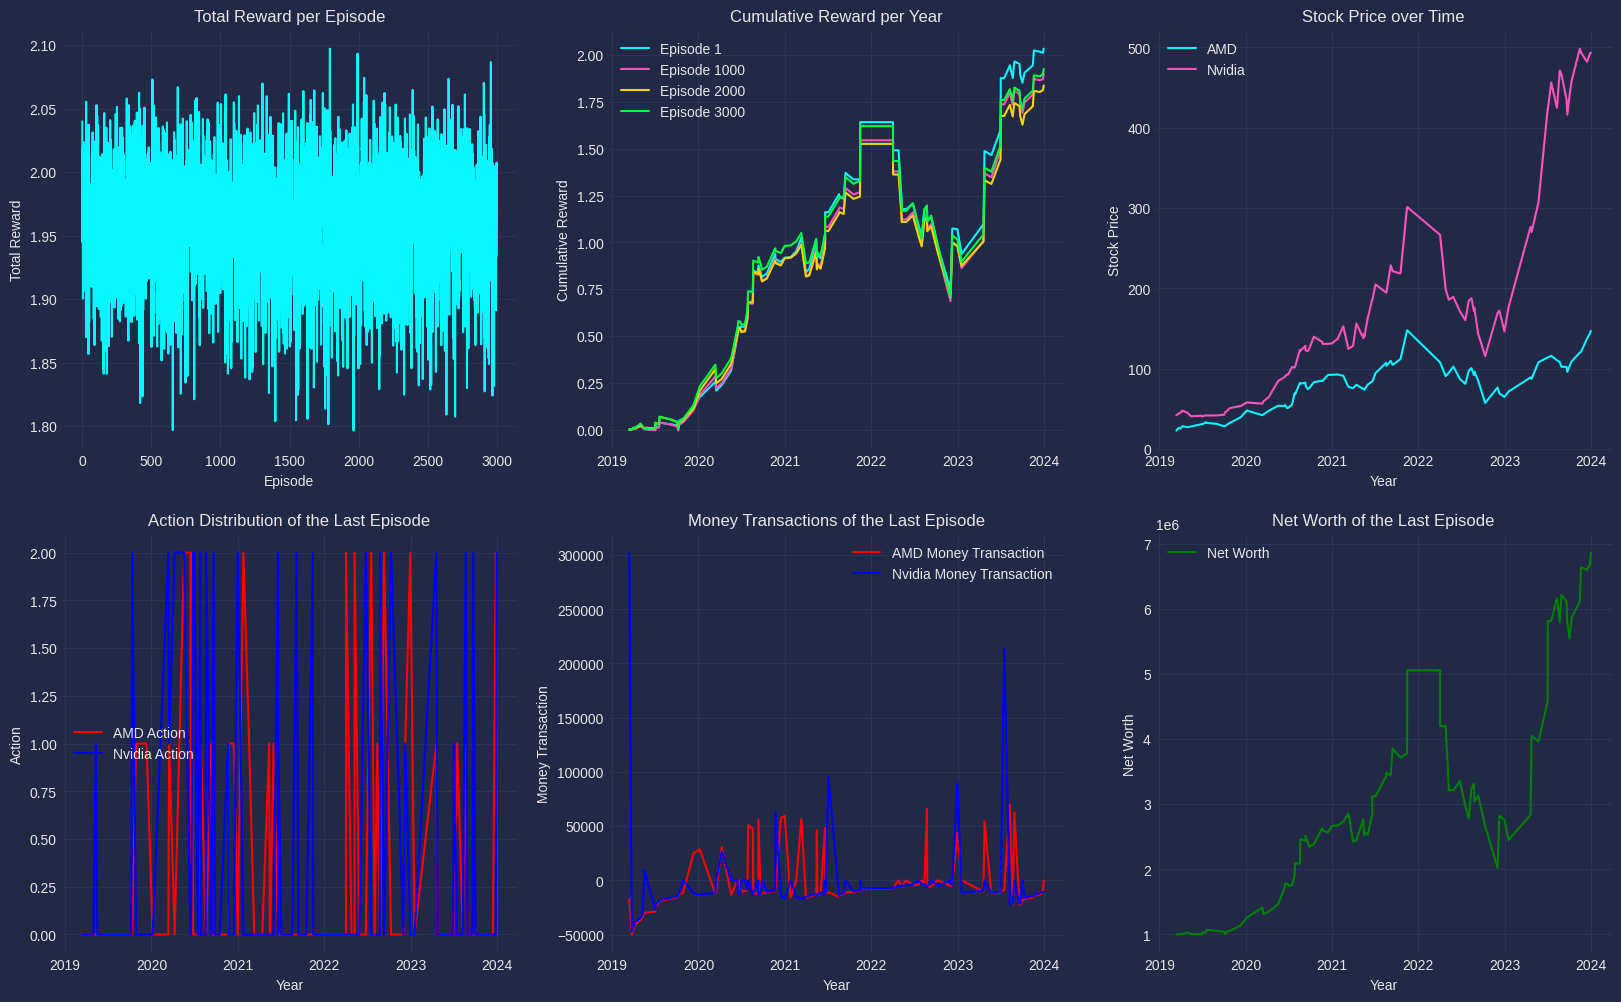

In [ ]:
# Train Q-learning with Sample Data with Best Hyperparameters
# Use the best parameters found from grid search
best_model_params = best_params

# Define the environment again for training
stock_data = StockData(sample_data, n_stocks=2)
env = SimpleTrader(stock_data)

# Set the seed for reproducibility
seed = 44
set_seed(seed)

# Train the model with the best hyperparameters
model = PPO('MlpPolicy', env, verbose=0, seed=seed, **best_model_params)

# Define the number of episodes and steps per episode
num_episodes = 3000
steps_per_episode = 100

# Calculate the total timesteps
total_timesteps = num_episodes * steps_per_episode

# Train the model
model.learn(total_timesteps=total_timesteps)

# Plotting the results after training with best hyperparameters
train_and_plot(env, num_episodes, steps_per_episode, model)


# RL Algorithms Training

## Ramdom Sample Data Generating function

In [ ]:
# Create random sample data for training models
def get_random_sample(df, sample_size):
    # Ensure the sample size is valid
    if sample_size <= 2:
        raise ValueError("Sample size should be greater than 2 to include the first and last available times.")

    # Select the first and last indices
    first_index = 0
    last_index = len(df) - 1

    # Choose random indices in between the first and last indices
    random_indices = np.random.choice(np.arange(1, last_index), size=sample_size - 2, replace=False)

    # Combine the first, random, and last indices
    indices = np.sort(np.concatenate(([first_index], random_indices, [last_index])))

    # Slice the DataFrame based on these sorted indices
    sample_data = df.iloc[indices].sort_values(by='DateTime')

    return sample_data

## Policy Network

In [ ]:
# Complex Policy Network training process with exploratory level
def train_policy_gradient(env, policy_network, optimizer, df, num_episodes, sample_size, exploratory_level, no_action_penalty):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start
    key_episodes = [1, 5000, 10000, 15000, 20000]

    for episode in range(num_episodes):
        sample_data = get_random_sample(df, sample_size)
        stock_data = StockData(sample_data)
        env = ComplexTrader(stock_data)
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            # Track actions, transactions and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            optimizer.zero_grad()
            reward_tensor = torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device)
            log_prob = action_dist.log_prob(action).sum()
            loss = -log_prob * reward_tensor
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
            optimizer.step()

            state = next_state
            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

        rewards.append(total_reward)
        if episode + 1 in key_episodes:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Ensure networth_last_episode contains only floats
    networth_last_episode = np.array([float(x) for x in networth_last_episode])

    # Convert money transactions to numpy array
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth (Reported): {final_net_worth_reported}")
    print(f"Final Net Worth (Calculated): {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Set up for cumulative rewards, stock prices, action distribution, net worth, and money transactions plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year (key episodes only)
    ax2 = axes[0, 1]
    for i in key_episodes:
        if i - 1 < num_episodes:
            ax2.plot(dates_per_episode[i - 1], cumulative_rewards_per_episode[i - 1], label=f'Episode {i}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year (Key Episodes)')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')
    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()


Initial state shape: (24,)
Input size to the network: 24
Training Policy Gradient with ComplexTrader...
Episode 1: Total Reward: [2.17998456], Balance: [74136.30903562], Net Worth: [8846169.670069], Shares (AMD: 736.7609844418319, Nvidia: 10366.236708048551)
Episode 5000: Total Reward: [1.42466729], Balance: [1651838.29469587], Net Worth: [4156474.72461565], Shares (AMD: 13881.109610594436, Nvidia: 20.44210351217084)
Episode 10000: Total Reward: [2.28243471], Balance: [8180342.57297413], Net Worth: [9800512.76900364], Shares (AMD: 252.76868758077813, Nvidia: 1751.1398206471717)
Episode 15000: Total Reward: [2.34689219], Balance: [4918.96380094], Net Worth: [10453033.17427088], Shares (AMD: 46317.90322540167, Nvidia: 4234.025886157205)
Episode 20000: Total Reward: [1.92449965], Balance: [233752.21032632], Net Worth: [6851719.56861632], Shares (AMD: 14617.362060436819, Nvidia: 4209.216880488378)
Initial Net Worth: 1000000
Final Net Worth (Reported): [6851719.56861632]
Final Net Worth (Ca

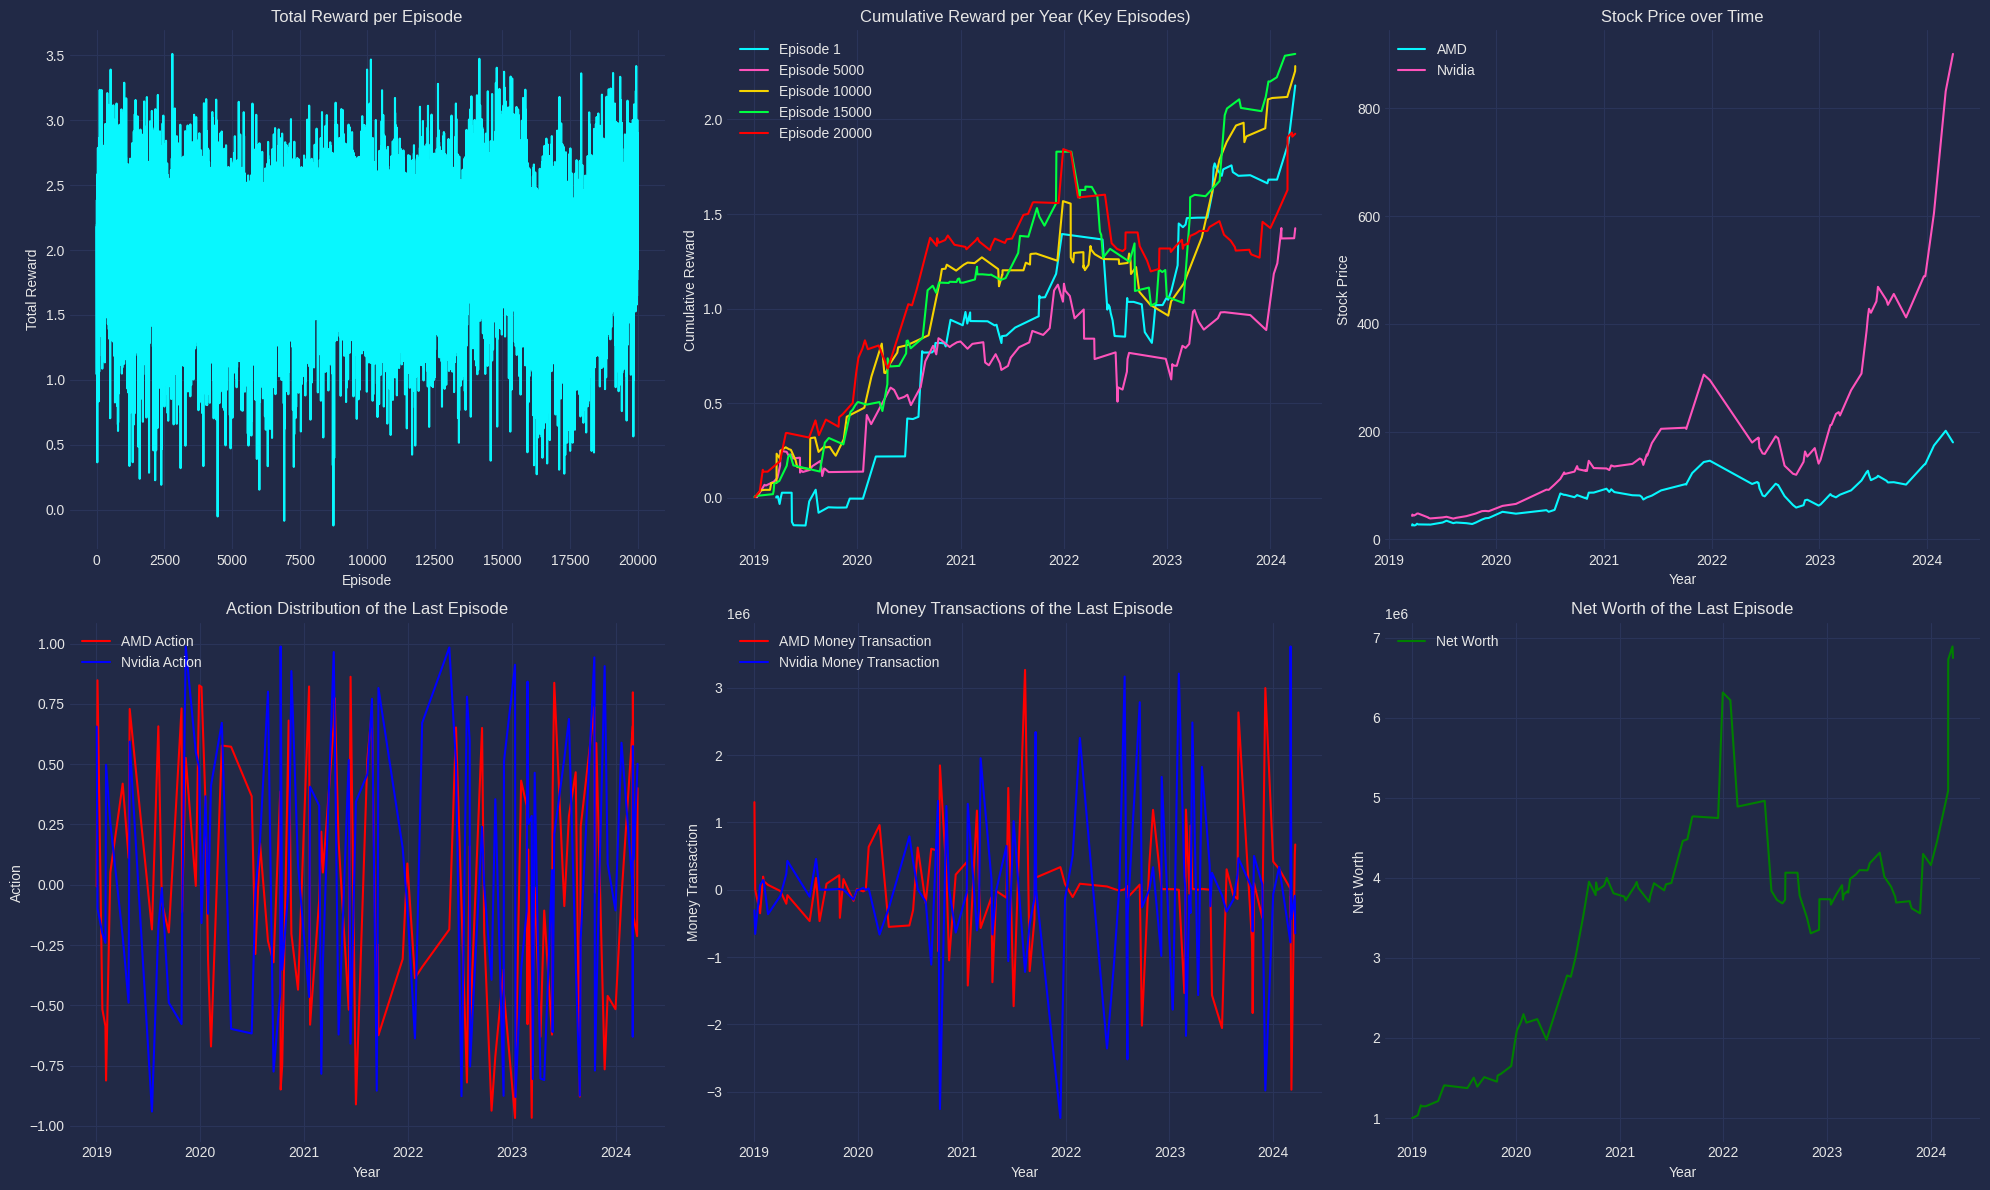

In [ ]:
# Train Policy Network with randomly picked dataset using the previously picked parameters

# Set the seed for reproducibility
seed = 101
set_seed(seed)

stock_data = StockData(sample_data)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()
print(f"Initial state shape: {initial_state.shape}")

input_size = len(initial_state)
print(f"Input size to the network: {input_size}")

hidden_size = 64
output_size = stock_data.n_stocks

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

print("Training Policy Gradient with ComplexTrader...")
train_policy_gradient(complex_trader_env, policy_network, policy_optimizer, df, num_episodes=20000, sample_size=100, exploratory_level=0.2, no_action_penalty=1)

## Policy Network with baseline

In [ ]:
# Complex Policy Network training process with baseline and exploratory level
def train_policy_gradient_with_baseline_complex(env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes, sample_size, exploratory_level, no_action_penalty=1):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start
    key_episodes = [1, 5000, 10000, 15000, 20000]

    for episode in range(num_episodes):
        sample_data = get_random_sample(df, sample_size)
        stock_data = StockData(sample_data)
        env = ComplexTrader(stock_data)
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0
        episode_states = []
        episode_rewards = []
        episode_actions = []

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            # Track actions, transactions, and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

            # Save the state, reward, and action
            episode_states.append(state_tensor)
            episode_rewards.append(torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device))

            # Calculate policy loss and update policy network
            policy_loss = -(action_dist.log_prob(action).sum().to(device) * (torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device) - value_network(state_tensor).detach())).mean()
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            episode_actions.append(action_dist.log_prob(action).sum().to(device))

            state = next_state

        rewards.append(total_reward)

        if episode + 1 in key_episodes:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

        # Compute the value targets and advantages
        episode_states = torch.cat(episode_states)
        episode_rewards = torch.cat(episode_rewards)
        value_estimates = value_network(episode_states)
        advantages = episode_rewards - value_estimates.detach()

        # Update the value network
        value_loss = F.mse_loss(value_estimates, episode_rewards)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Ensure networth_last_episode contains only floats
    networth_last_episode = np.array([float(x) for x in networth_last_episode])

    # Convert money transactions to numpy array
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Set up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and money transactions plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year (key episodes only)
    ax2 = axes[0, 1]
    for i in key_episodes:
        if i - 1 < num_episodes:
            ax2.plot(dates_per_episode[i - 1], cumulative_rewards_per_episode[i - 1], label=f'Episode {i}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year (Key Episodes)')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')
    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()


Initial state shape: (24,)
Input size to the network: 24
Training Policy Gradient with Baseline and ComplexTrader...
Episode 1: Total Reward: [1.71735425], Balance: [46877.61422816], Net Worth: [5569772.73342362], Shares (AMD: 23543.255981021935, Nvidia: 812.1554116698736)
Episode 5000: Total Reward: [2.24010949], Balance: [300255.12317208], Net Worth: [9394359.8054027], Shares (AMD: 6320.132120288239, Nvidia: 10993.983759414243)
Episode 10000: Total Reward: [2.5592344], Balance: [1878.07244416], Net Worth: [12925917.50448145], Shares (AMD: 60934.51913174427, Nvidia: 497.20272942003265)
Episode 15000: Total Reward: [3.2504448], Balance: [2.46887129e-123], Net Worth: [25801814.13662552], Shares (AMD: 27875.056878910967, Nvidia: 22129.71629355222)
Episode 20000: Total Reward: [2.79116118], Balance: [1.48479142e-164], Net Worth: [16299935.9187611], Shares (AMD: 14634.389451716566, Nvidia: 25172.9996654171)
Initial Net Worth: 1000000
Final Net Worth: 16299935.918761095
Net Worth Change: 15

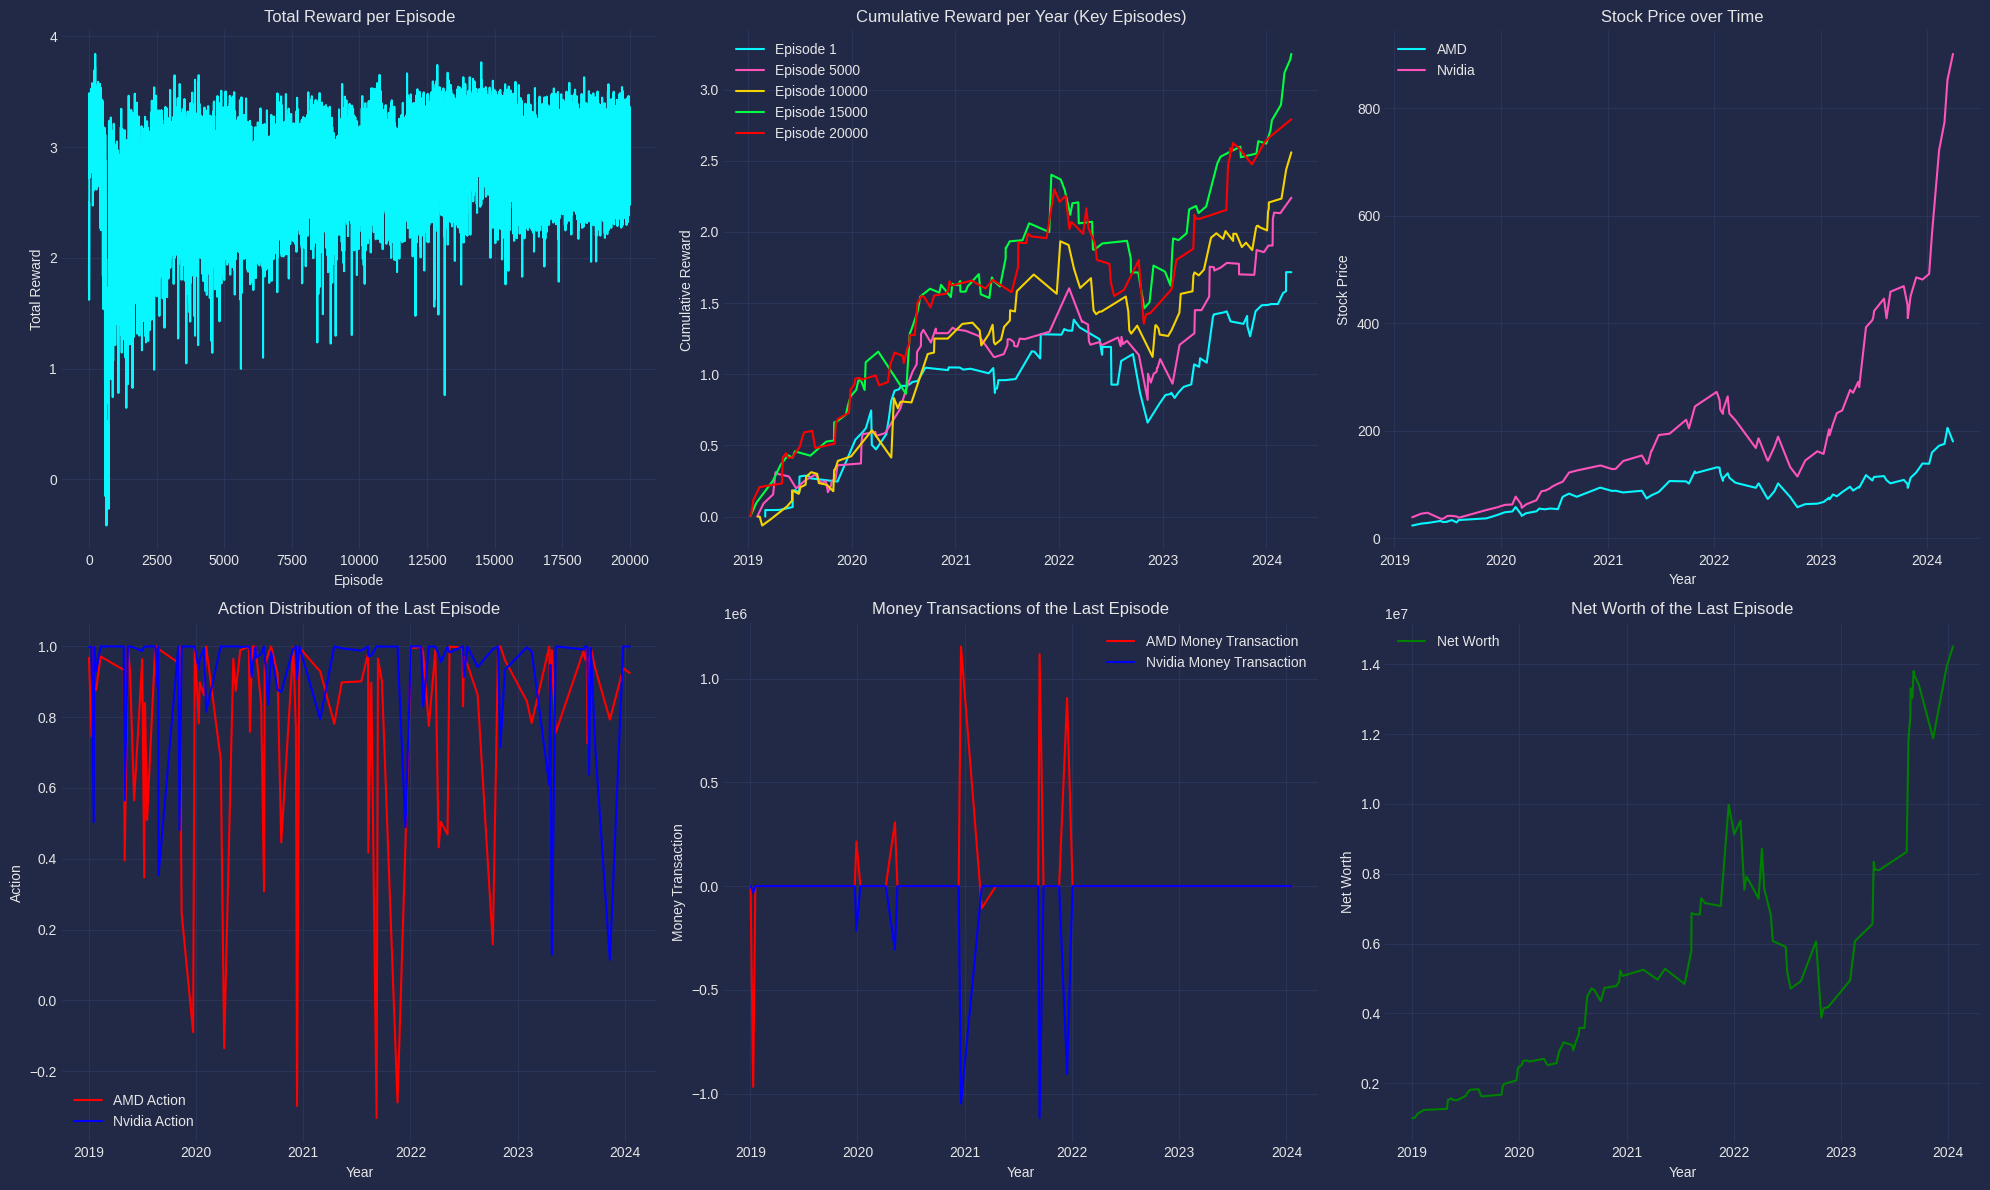

In [ ]:
# Train Policy Network with baseline with randomly picked dataset using the previously picked parameters

# Set the seed for reproducibility
seed = 202
set_seed(seed)

stock_data = StockData(df)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()
print(f"Initial state shape: {initial_state.shape}")

input_size = len(initial_state)
print(f"Input size to the network: {input_size}")

hidden_size = 64
output_size = stock_data.n_stocks

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

value_network = ValueNetwork(input_size, hidden_size)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.001)

print("Training Policy Gradient with Baseline and ComplexTrader...")
train_policy_gradient_with_baseline_complex(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes=20000, sample_size=100, exploratory_level=0.1, no_action_penalty=1)


## Actor-Critic with Epsilon-Greedy

In [ ]:
# Complex Actor-Critic with Epsilon-Greedy training function
def train_actor_critic_with_epsilon_greedy_complex(env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes, sample_size, exploratory_level, epsilon_start, epsilon_end, epsilon_decay, no_action_penalty=1):
    epsilon = epsilon_start
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []
    key_episodes = [1, 5000, 10000, 15000, 20000]

    policy_network.to(device)
    value_network.to(device)

    initial_net_worth = 1000000  # Initial net worth at the start

    for episode in range(num_episodes):
        sample_data = get_random_sample(df, sample_size)
        stock_data = StockData(sample_data)
        env = ComplexTrader(stock_data)
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            if random.random() < epsilon:
                action_np = env.action_space.sample()
                log_prob = torch.tensor(0.0, requires_grad=True)  # No log probability for random action
            else:
                alpha, beta = policy_network(state_tensor)
                action_dist = torch.distributions.Beta(alpha, beta)
                if random.random() < prob_rand_action:
                    action = torch.rand(2)
                    action_np = 2 * action.cpu().numpy() - 1
                else:
                    action = action_dist.sample()
                    action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                    action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]
                log_prob = action_dist.log_prob(action).sum()

            # Track actions, transactions, and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            next_state = np.array(next_state, dtype=np.float32)

            value = value_network(state_tensor)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            next_value = value_network(next_state_tensor)

            reward_tensor = torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device)
            advantage = reward_tensor + (1 - done) * next_value - value

            policy_optimizer.zero_grad()
            policy_loss = -log_prob * advantage.detach()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
            policy_optimizer.step()

            value_optimizer.zero_grad()
            value_loss = advantage.pow(2).mean()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_network.parameters(), max_norm=1.0)
            value_optimizer.step()

            state = next_state
            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards.append(total_reward)
        if episode + 1 in key_episodes:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Ensure networth_last_episode contains only floats
    networth_last_episode = np.array([float(x) for x in networth_last_episode])

    # Convert money transactions to numpy array
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Set up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and money transactions plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year (key episodes only)
    ax2 = axes[0, 1]
    for i in key_episodes:
        if i - 1 < num_episodes:
            ax2.plot(dates_per_episode[i - 1], cumulative_rewards_per_episode[i - 1], label=f'Episode {i}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year (Key Episodes)')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')
    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()


Initial state shape: (24,)
Input size to the network: 24
Training Actor-Critic with Epsilon-Greedy and ComplexTrader...
Episode 1: Total Reward: [2.60417582], Balance: [5249080.22555953], Net Worth: [13520077.69312025], Shares (AMD: 8448.608437411232, Nvidia: 6861.805569193771)
Episode 5000: Total Reward: [2.25146821], Balance: [2.18546755], Net Worth: [9501676.09987094], Shares (AMD: 52524.48406219901, Nvidia: 0.0)
Episode 10000: Total Reward: [2.69461964], Balance: [4.41894195e-47], Net Worth: [14799888.38470671], Shares (AMD: 71531.60166605464, Nvidia: 0.0)
Episode 15000: Total Reward: [2.21634892], Balance: [2.48001564e-134], Net Worth: [9173775.42598687], Shares (AMD: 51465.2322134399, Nvidia: 0.0)
Episode 20000: Total Reward: [2.31845841], Balance: [-1.6e-322], Net Worth: [10159999.67998112], Shares (AMD: 55555.55380567103, Nvidia: 0.0)
Initial Net Worth: 1000000
Final Net Worth: 10159999.679981118
Net Worth Change: 9159999.679981118
Return Percentage Calculation: 915.99996799811

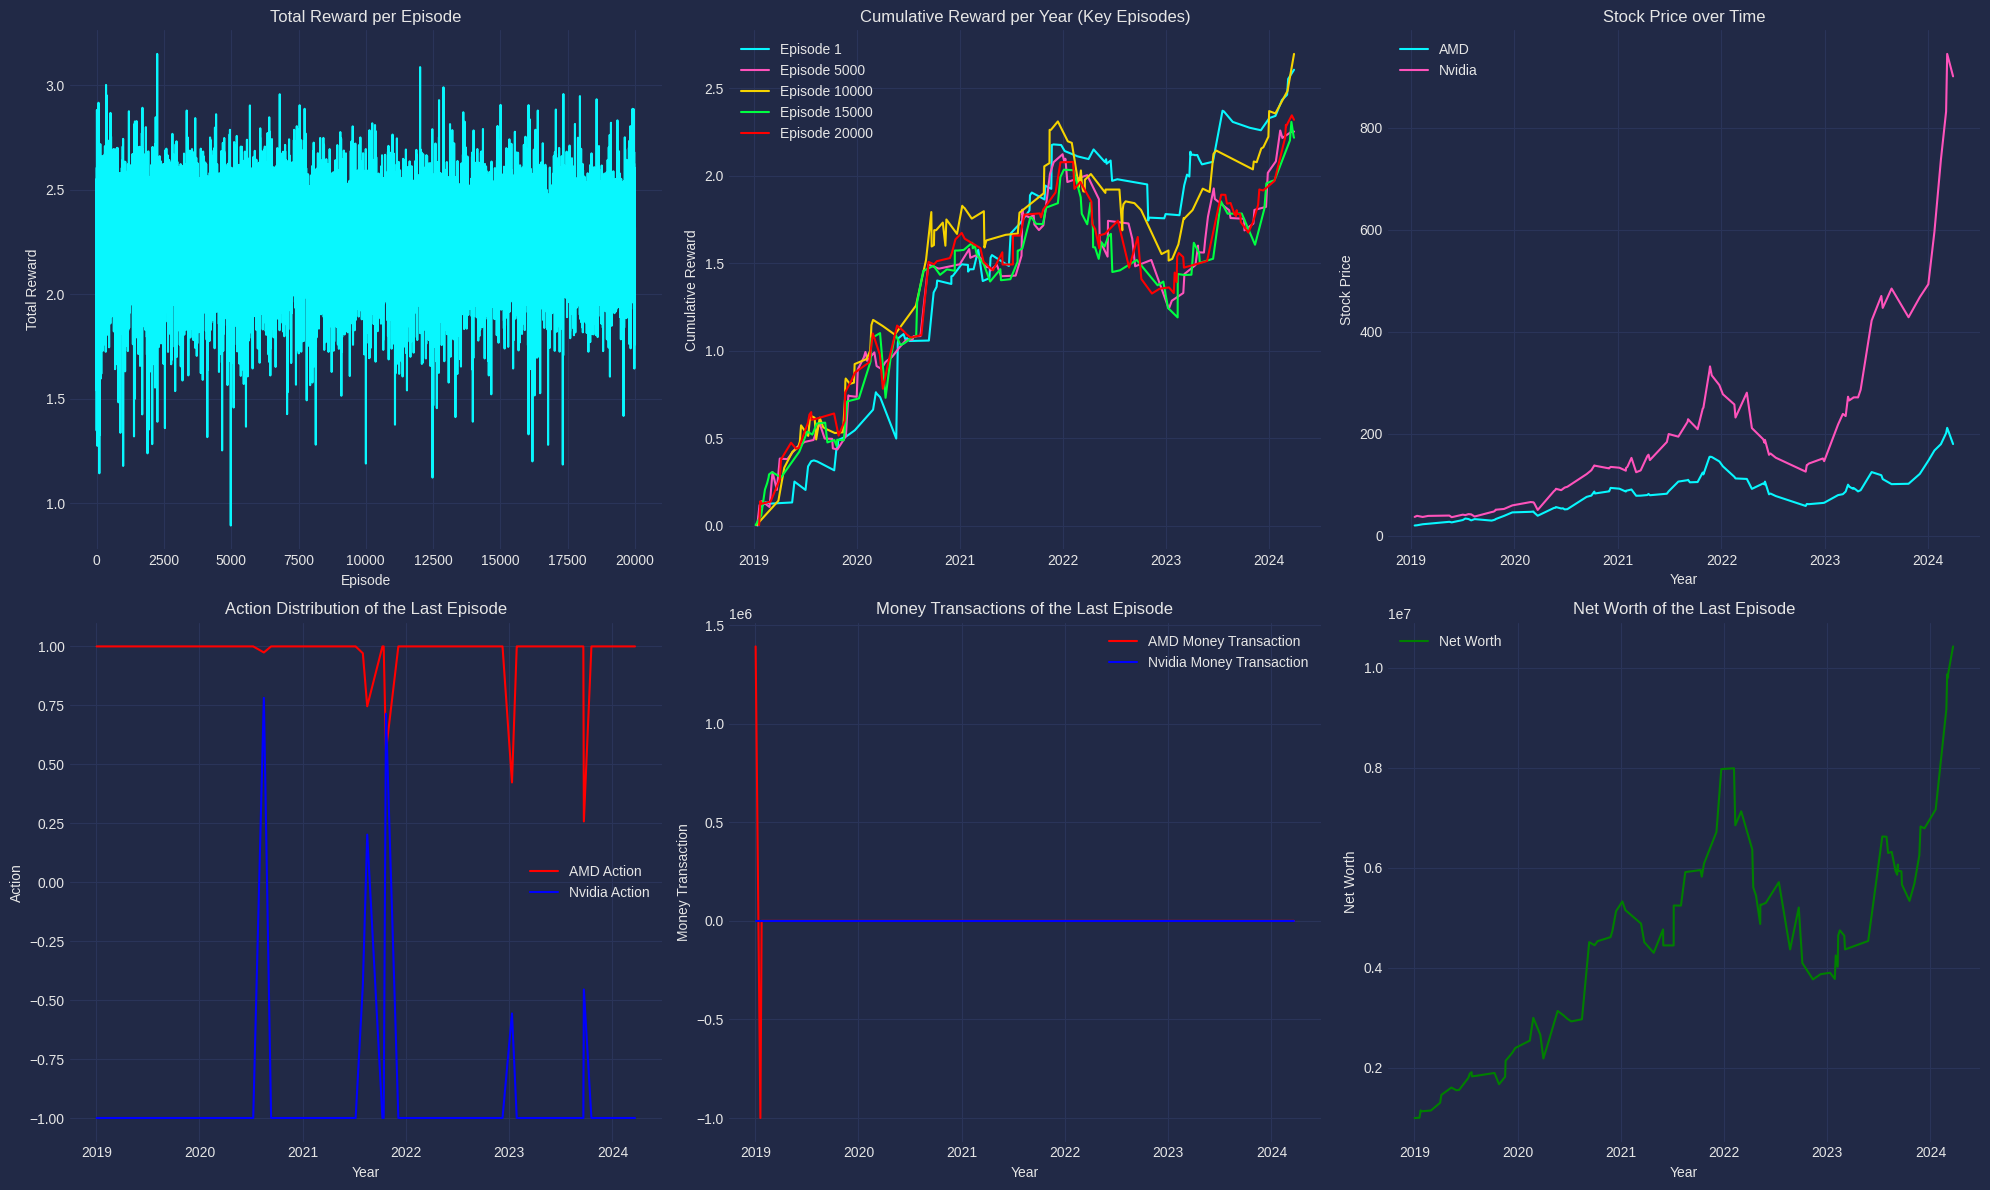

In [ ]:
# Train Actor-Critic with Epsilon-Greedy and randomly picked dataset

# Set the seed for reproducibility
seed = 303
set_seed(seed)

stock_data = StockData(df)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()
print(f"Initial state shape: {initial_state.shape}")

input_size = len(initial_state)
print(f"Input size to the network: {input_size}")

hidden_size = 64
output_size = stock_data.n_stocks

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
value_network = ValueNetwork(input_size, hidden_size)

policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.001)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.001)

print("Training Actor-Critic with Epsilon-Greedy and ComplexTrader...")
train_actor_critic_with_epsilon_greedy_complex(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes=20000, sample_size=100, exploratory_level=0.1, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.99, no_action_penalty=1)

## Deep Q-learning

In [ ]:
# Define Complex Q-learning Training and Plotting Function

# Training function
def train_and_plot(env, num_episodes, steps_per_episode, sample_size, model):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode_amd = []
    actions_last_episode_nvda = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start

    for episode in range(num_episodes):
        sample_data = get_random_sample(df, sample_size)
        stock_data = StockData(sample_data, n_stocks=2)
        env = SimpleTrader(stock_data)
        state, _ = env.reset(seed=seed)
        done = False
        total_reward = 0
        cumulative_reward = 0

        for step in range(steps_per_episode):
            action, _states = model.predict(state, deterministic=False)

            # Record information after taking the action
            cumulative_rewards_per_episode[episode].append(cumulative_reward)
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])
            if episode == num_episodes - 1:
                actions_last_episode_amd.append(action[0])
                actions_last_episode_nvda.append(action[1])
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(float(env.networth))
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            # Take the action
            next_state, reward, done, truncated, info = env.step(action)

            # Update state and rewards
            state = next_state
            total_reward += reward
            cumulative_reward += reward

            if done:
                break

        rewards.append(total_reward)
        if episode + 1 in [1, 5000, 10000, 15000, 20000]:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert actions of the last episode to numpy array
    actions_array_amd = np.array(actions_last_episode_amd)
    actions_array_nvda = np.array(actions_last_episode_nvda)

    # Ensure networth_last_episode contains only floats
    networth_last_episode = np.array([float(x) for x in networth_last_episode])

    # Convert money transactions to numpy array
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array_amd), len(actions_array_nvda), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array_amd = actions_array_amd[:min_length]
    actions_array_nvda = actions_array_nvda[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Setting up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and transaction plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year
    ax2 = axes[0, 1]
    for i in [0, 4999, 9999, 14999, 19999]:
        if i < num_episodes:
            ax2.plot(dates_per_episode[i], cumulative_rewards_per_episode[i], label=f'Episode {i + 1}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution for AMD and Nvidia
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array_amd, 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array_nvda, 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')

    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.show()

Episode 1: Total Reward: 2.612889490126854, Balance: [99055.58], Net Worth: 13638402.0, Shares (AMD: 1433.226806640625, Nvidia: 14978.703125)
Episode 5000: Total Reward: 2.7193919475158275, Balance: [267964.66], Net Worth: 15171098.0, Shares (AMD: 1237.051513671875, Nvidia: 17156.650390625)
Episode 10000: Total Reward: 2.7276066760848163, Balance: [771401.06], Net Worth: 15296235.0, Shares (AMD: 2677.4501953125, Nvidia: 15299.478515625)
Episode 15000: Total Reward: 2.6066682772710905, Balance: [291562.97], Net Worth: 13553821.0, Shares (AMD: 848.3428955078125, Nvidia: 15522.6376953125)
Episode 20000: Total Reward: 2.6664100798232404, Balance: [701251.06], Net Worth: 14388227.0, Shares (AMD: 1946.8651123046875, Nvidia: 14804.0712890625)
Initial Net Worth: 1000000
Final Net Worth: 14388227.0
Net Worth Change: 13388227.0
Return Percentage Calculation: 1338.8227
Last Episode Return%: 1338.82%
Last Episode Sharpe Ratio: 4.64
Last Episode Maximum Drawdown: 3250999.00
Last Episode Hit Ratio: 

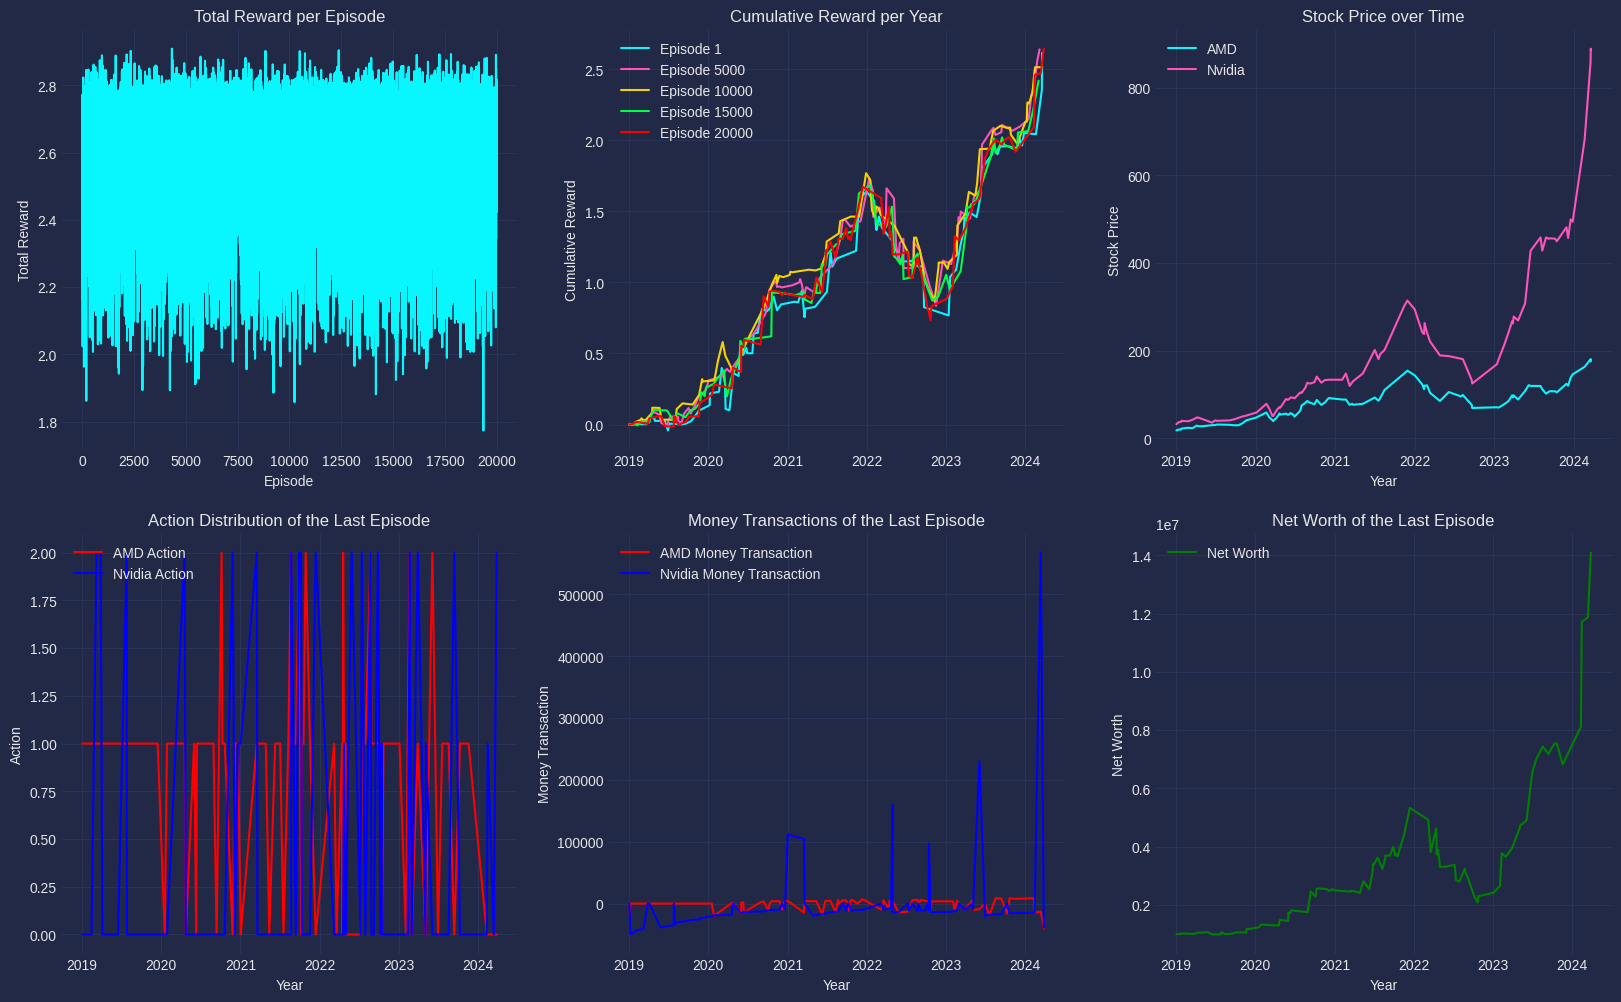

In [ ]:
# Train Q-learning with Full Random Data with Best Hyperparameters
# Use the best parameters found from grid search
best_model_params = best_params

# Set the seed for reproducibility
seed = 404
set_seed(seed)

# Train the model with the best hyperparameters
model = PPO('MlpPolicy', env, verbose=0, seed=seed, **best_model_params)

# Define the number of episodes, steps and sample size per episode
num_episodes = 20000
steps_per_episode = 100
sample_size = 100

# Calculate the total timesteps
total_timesteps = num_episodes * steps_per_episode

# Train the model
model.learn(total_timesteps=total_timesteps)

# Plotting the results after training with best hyperparameters
train_and_plot(env, num_episodes, steps_per_episode, sample_size, model)

#Time-series incorporation

##ARIMA with Policy Network with Baseline

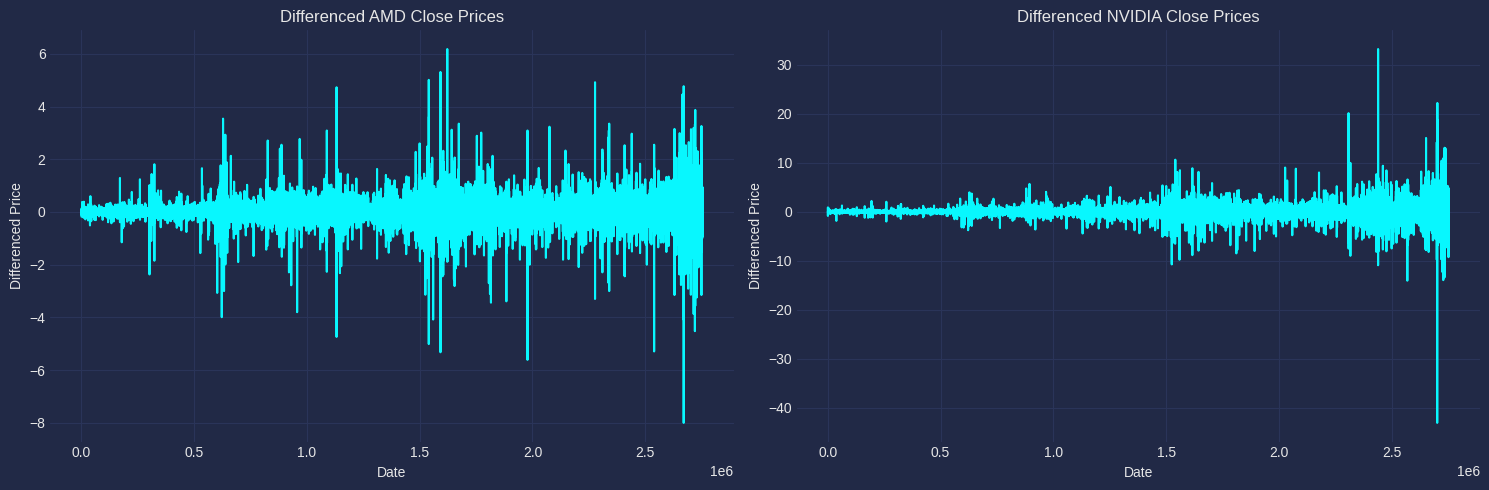

In [ ]:
# Differencing the Time-series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
amd_diff = df['AMD_Close'].diff().dropna()
nvda_diff = df['NVDA_Close'].diff().dropna()

# Plotting AMD differenced series
amd_diff.plot(ax=axes[0], title='Differenced AMD Close Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Differenced Price')

# Plotting NVIDIA differenced series
nvda_diff.plot(ax=axes[1], title='Differenced NVIDIA Close Prices')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Differenced Price')

plt.tight_layout()
plt.show()

In [ ]:
# Checking the Differencing of the Time-series
from statsmodels.tsa.stattools import adfuller

# Select the last 100,000 observations
amd_diff_sample = amd_diff[-100000:]
nvda_diff_sample = nvda_diff[-100000:]

def check_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f'{title} Stationarity Check:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

# Check stationarity for the differenced sample series
check_stationarity(amd_diff_sample, 'Differenced AMD Close Prices Sample')
check_stationarity(nvda_diff_sample, 'Differenced NVIDIA Close Prices Sample')


Differenced AMD Close Prices Sample Stationarity Check:
ADF Statistic: -37.973909
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Differenced NVIDIA Close Prices Sample Stationarity Check:
ADF Statistic: -37.668471
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567




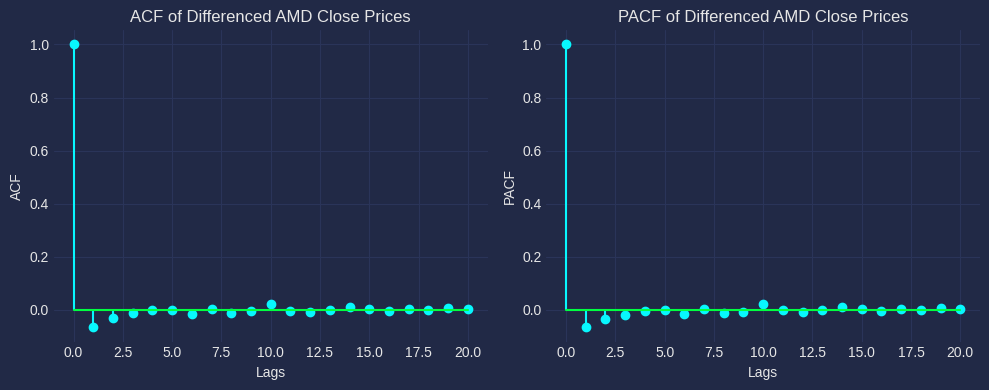

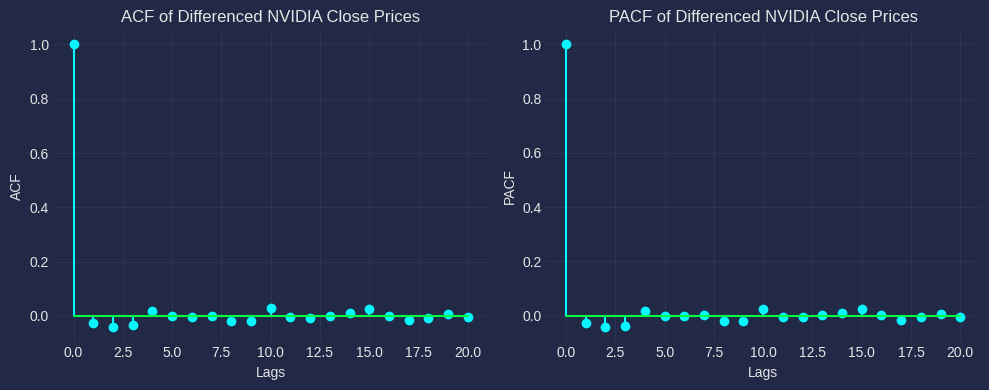

In [ ]:
#Plot ACF and PACF of the differenced series to identify potential values for p and q
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Compute ACF and PACF using FFT
acf_amd = acf(amd_diff_sample, fft=True, nlags=20)
pacf_amd = pacf(amd_diff_sample, nlags=20)

acf_nvda = acf(nvda_diff_sample, fft=True, nlags=20)
pacf_nvda = pacf(nvda_diff_sample, nlags=20)

# Plot ACF for AMD
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.stem(range(len(acf_amd)), acf_amd, use_line_collection=True)
plt.title('ACF of Differenced AMD Close Prices')
plt.xlabel('Lags')
plt.ylabel('ACF')

# Plot PACF for AMD
plt.subplot(122)
plt.stem(range(len(pacf_amd)), pacf_amd, use_line_collection=True)
plt.title('PACF of Differenced AMD Close Prices')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.tight_layout()
plt.show()

# Plot ACF for NVIDIA
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.stem(range(len(acf_nvda)), acf_nvda, use_line_collection=True)
plt.title('ACF of Differenced NVIDIA Close Prices')
plt.xlabel('Lags')
plt.ylabel('ACF')

# Plot PACF for NVIDIA
plt.subplot(122)
plt.stem(range(len(pacf_nvda)), pacf_nvda, use_line_collection=True)
plt.title('PACF of Differenced NVIDIA Close Prices')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

def train_arima_models(amd_diff, nvda_diff):
    # Fit ARIMA models on differenced data with d=1, and p, q seprately based on ACF and PACF plots
    amd_model = ARIMA(amd_diff, order=(2, 1, 2))
    nvda_model = ARIMA(nvda_diff, order=(3, 1, 3))

    amd_model_fit = amd_model.fit()
    nvda_model_fit = nvda_model.fit()

    return amd_model_fit, nvda_model_fit

# Train the models using the differenced series
amd_model_fit, nvda_model_fit = train_arima_models(amd_diff, nvda_diff)


In [ ]:
# Save the trained models
import pickle

save_path = "/content/drive/MyDrive/Dissertation/Trained Models"
os.makedirs(save_path, exist_ok=True)

# Save the ARIMA models
amd_arima_path = os.path.join(save_path, "arima_amd.pkl")
nvda_arima_path = os.path.join(save_path, "arima_nvda.pkl")

with open(amd_arima_path, 'wb') as f:
    pickle.dump(amd_model_fit, f)

with open(nvda_arima_path, 'wb') as f:
    pickle.dump(nvda_model_fit, f)

print("ARIMA models saved successfully.")

ARIMA models saved successfully.


In [ ]:
# Load the ARIMA models
import os
import pickle

# Read where the models are saved
save_path = "/content/drive/MyDrive/Dissertation/Trained Models"
amd_arima_path = os.path.join(save_path, "arima_amd.pkl")
nvda_arima_path = os.path.join(save_path, "arima_nvda.pkl")

with open(amd_arima_path, 'rb') as f:
    amd_model_fit = pickle.load(f)

with open(nvda_arima_path, 'rb') as f:
    nvda_model_fit = pickle.load(f)

print("ARIMA models loaded successfully.")

ARIMA models loaded successfully.


In [ ]:
# Evaluate the predicting accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error

def reverse_differencing(diff_series, initial_value):

    return np.r_[initial_value, diff_series].cumsum()

def evaluate_arima_model_in_batches(model_fit, original_series, batch_size=32):

    n = len(original_series)
    num_batches = int(np.ceil((n - 1) / batch_size))

    predictions = []
    actual_values = original_series[1:]  # skip the first value for comparison

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n - 2)

        # Generate predictions
        pred_diff = model_fit.predict(start=start_idx, end=end_idx)

        # Reverse the differencing
        initial_value = original_series[start_idx]
        pred_values = reverse_differencing(pred_diff, initial_value)

        predictions.extend(pred_values[1:])  # skip the initial value added for reverse differencing

    # Convert predictions to numpy array
    predictions = np.array(predictions)

    # Ensure that predictions length matches the actual values length
    if len(predictions) > len(actual_values):
        predictions = predictions[:len(actual_values)]

    # Calculate MSE and MAE
    mse = mean_squared_error(actual_values, predictions)
    mae = mean_absolute_error(actual_values, predictions)

    return mse, mae, predictions

# Evaluate the AMD ARIMA model
mse_amd, mae_amd, predictions_amd = evaluate_arima_model_in_batches(
    amd_model_fit,
    df['AMD_Close'].values,  # original series before differencing
    batch_size=32
)
print(f"AMD ARIMA Model - MSE: {mse_amd}, MAE: {mae_amd}")

# Evaluate the NVIDIA ARIMA model
mse_nvda, mae_nvda, predictions_nvda = evaluate_arima_model_in_batches(
    nvda_model_fit,
    df['NVDA_Close'].values,  # original series before differencing
    batch_size=32
)
print(f"NVIDIA ARIMA Model - MSE: {mse_nvda}, MAE: {mae_nvda}")

AMD ARIMA Model - MSE: 238.4254113367381, MAE: 10.285187071191295
NVIDIA ARIMA Model - MSE: 3897.6044852233604, MAE: 31.646177680008076


In [ ]:
# Update the StockData Class to Include ARIMA Predictions
warnings.filterwarnings("ignore")
class StockData:
   def __init__(self, df, amd_model_fit, nvda_model_fit, n_stocks=2):
       self.df = df
       self.amd_model_fit = amd_model_fit
       self.nvda_model_fit = nvda_model_fit
       self.n_stocks = n_stocks
       self.shape = self.get_state(0).shape

   def get_state(self, time_index):
       current_state = self.df.iloc[time_index][[
           'AMD_Open', 'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume', 'AMD_Google Trends',
           'NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume', 'NVDA_Google Trends',
           'S&P 500', 'NASDAQ-100', 'PHLX Semiconductor', 'Inflation Rate',
           'Federal Reserve Interest Rate', 'Consumer Confidence Index', 'Effective Federal Fund Rate',
           'Oil Prices', 'Gold Prices'
       ]]
       current_state['S&P 500'] *= 1e-2
       current_state['NASDAQ-100'] *= 1e-2
       current_state['PHLX Semiconductor'] *= 1e-2

       # Get ARIMA predictions
       amd_prediction = self.amd_model_fit.predict(start=time_index, end=time_index+1).iloc[1]
       nvda_prediction = self.nvda_model_fit.predict(start=time_index, end=time_index+1).iloc[1]

       current_state['AMD_ARIMA_Prediction'] = amd_prediction
       current_state['NVDA_ARIMA_Prediction'] = nvda_prediction

       return current_state.values

   def get_sell_price(self, time_index):
       sell_price = np.array([
           self.df.iloc[time_index]['AMD_Open'],
           self.df.iloc[time_index]['NVDA_Open']
       ])
       return sell_price

   def get_buy_price(self, time_index):
       buy_price = np.array([
           self.df.iloc[time_index]['AMD_Close'],
           self.df.iloc[time_index]['NVDA_Close']
       ])

       return buy_price

# Initialise stock data with ARIMA model fits
stock_data = StockData(df, amd_model_fit, nvda_model_fit, n_stocks=2)

# Initialise the environment
env = ComplexTrader(stock_data)
state = env.reset()
print(f"Initial state: {state}")

Initial state: [18.09 18.09 18.0 18.0 2054.0 60 32.5 32.5 32.3825 32.3825 2226.0 87
 25.10030029296875 63.608701171875005 11.65300048828125 252.561 2.4 91.2
 2.4 46.540000915527344 1281.0 -0.1799999991054752 0.0 1000000.0 0.0 0.0]


In [ ]:
# Complex Time-series Incorporated Policy Network with Baseline training process
def train_policy_gradient_with_baseline_complex(env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes, sample_size, exploratory_level, no_action_penalty=1):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start
    key_episodes = [1, 1000, 2000, 3000, 4000, 5000]

    for episode in range(num_episodes):
        sample_data = get_random_sample(df, sample_size)
        stock_data = StockData(sample_data, amd_model_fit, nvda_model_fit, n_stocks=2)  # pass ARIMA model fits here
        env = ComplexTrader(stock_data)
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0
        episode_states = []
        episode_rewards = []
        episode_actions = []

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            # Track actions, transactions, and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

            # Save the state, reward, and action
            episode_states.append(state_tensor)
            episode_rewards.append(torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device))

            # Calculate policy loss and update policy network
            policy_loss = -(action_dist.log_prob(action).sum().to(device) * (torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device) - value_network(state_tensor).detach())).mean()
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            episode_actions.append(action_dist.log_prob(action).sum().to(device))

            state = next_state

        rewards.append(total_reward)

        if episode + 1 in key_episodes:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

        # Compute the value targets and advantages
        episode_states = torch.cat(episode_states)
        episode_rewards = torch.cat(episode_rewards)
        value_estimates = value_network(episode_states)
        advantages = episode_rewards - value_estimates.detach()

        # Update the value network
        value_loss = F.mse_loss(value_estimates, episode_rewards)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Ensure networth_last_episode contains only floats
    networth_last_episode = np.array([float(x) for x in networth_last_episode])

    # Convert money transactions to numpy array
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Set up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and money transactions plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year (key episodes only)
    ax2 = axes[0, 1]
    for i in key_episodes:
        if i - 1 < num_episodes:
            ax2.plot(dates_per_episode[i - 1], cumulative_rewards_per_episode[i - 1], label=f'Episode {i}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year (Key Episodes)')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')
    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()

Initial state shape: (26,)
Input size to the network: 26
Training Time-series in Policy Gradient with Baseline and ComplexTrader...
Episode 1: Total Reward: [2.0497878], Balance: [4294604.5213989], Net Worth: [7766252.9301021], Shares (AMD: 13142.747264848704, Nvidia: 1662.8940313983042)
Episode 1000: Total Reward: [2.32762707], Balance: [0.65146388], Net Worth: [10253581.58209197], Shares (AMD: 52338.221278281286, Nvidia: 0.0)
Episode 2000: Total Reward: [2.37840761], Balance: [7.4e-323], Net Worth: [10787710.94832178], Shares (AMD: 53938.554741608896, Nvidia: 0.0)
Episode 3000: Total Reward: [2.3067563], Balance: [2.24595552e-285], Net Worth: [10041799.13944612], Shares (AMD: 56177.89728361464, Nvidia: 0.0)
Episode 4000: Total Reward: [2.30065137], Balance: [2.19331094e-60], Net Worth: [9980681.4702197], Shares (AMD: 49117.623608607995, Nvidia: 0.0)
Episode 5000: Total Reward: [2.28809162], Balance: [1.14e-322], Net Worth: [9856110.54745749], Shares (AMD: 55555.55237843127, Nvidia: 0

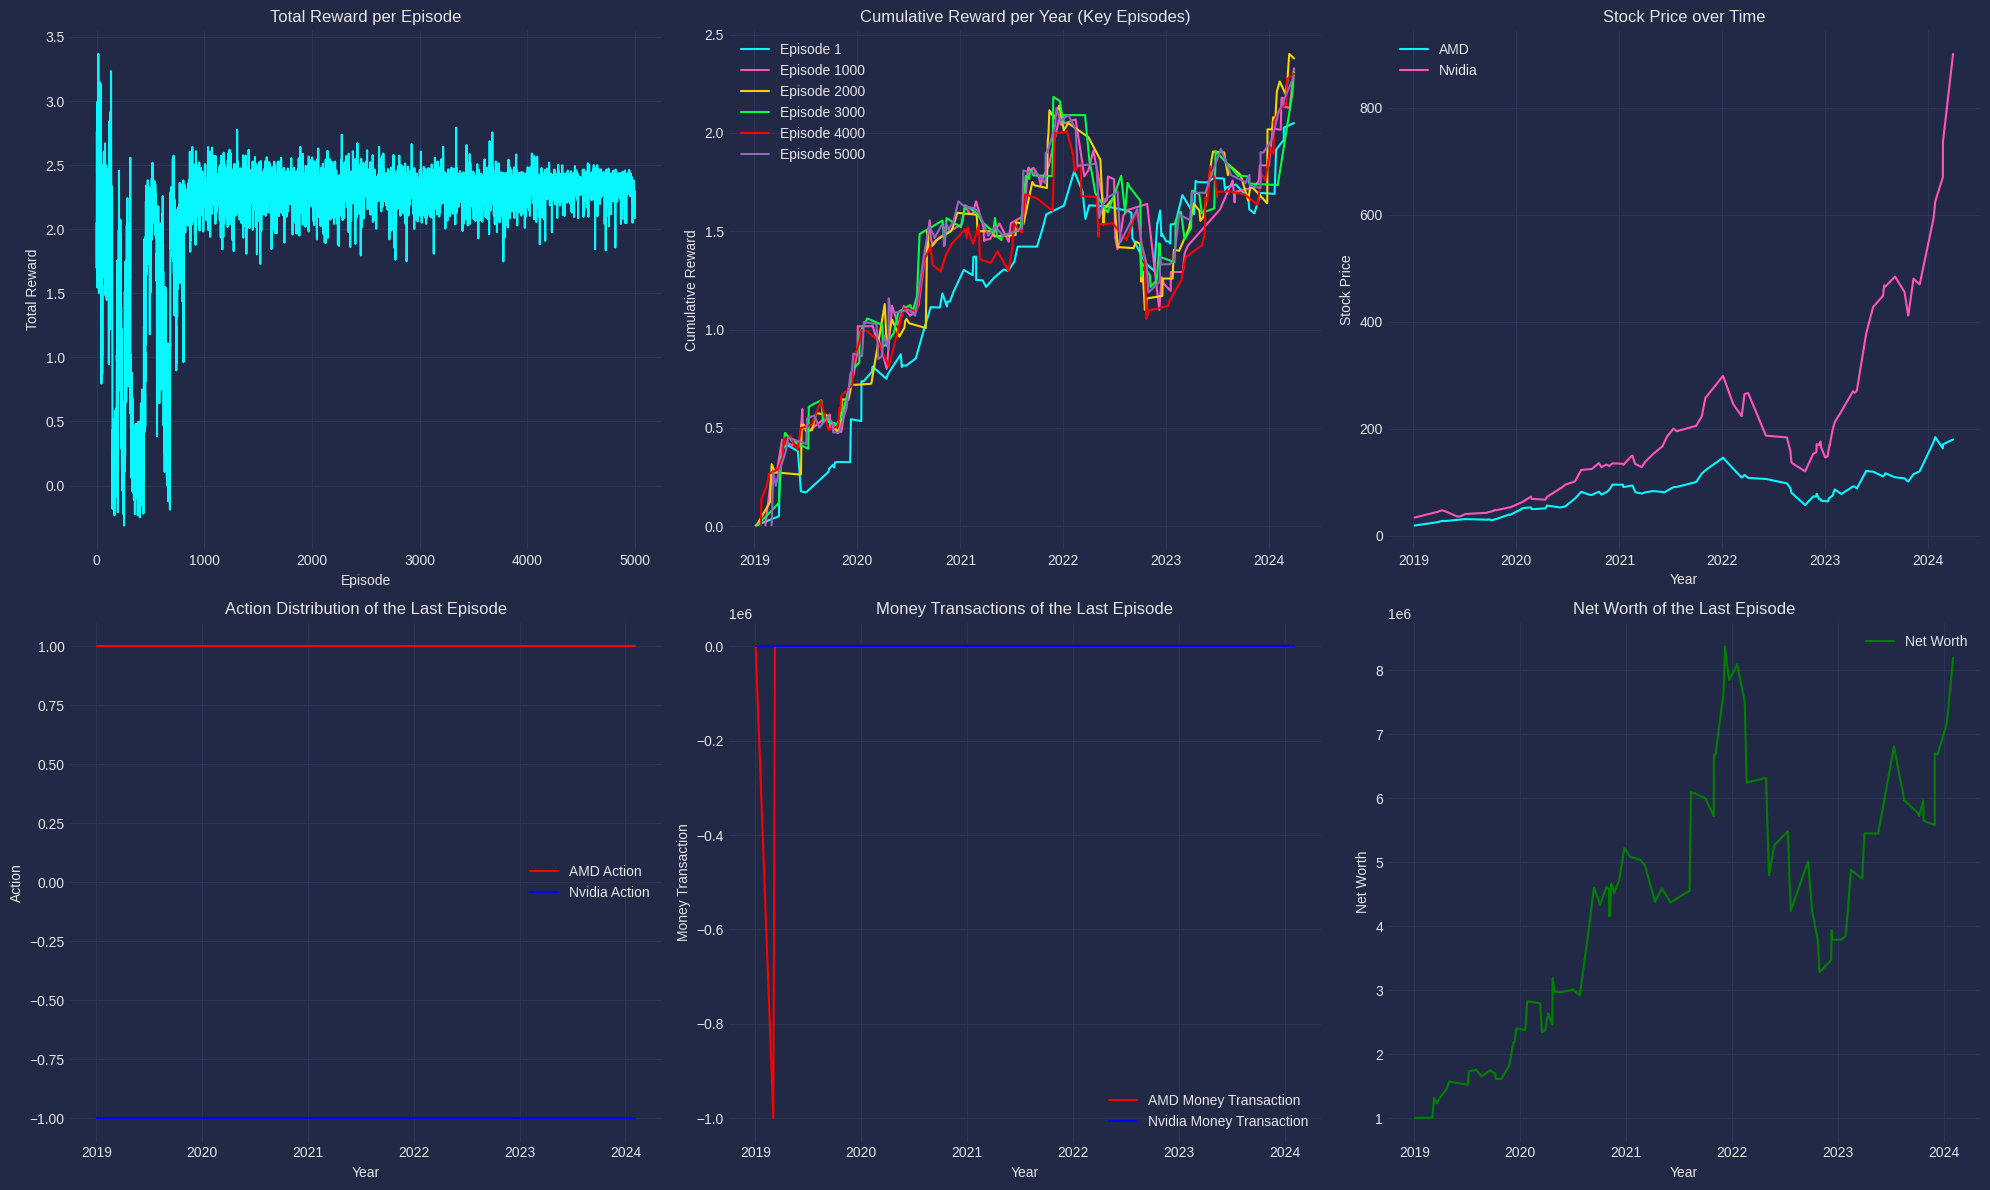

In [ ]:
# Train Complex Time-series Incorporated Policy Network with Baseline using the previously picked parameters

# Set the seed for reproducibility
seed = 5
set_seed(seed)

stock_data = StockData(df, amd_model_fit, nvda_model_fit, n_stocks=2)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()
print(f"Initial state shape: {initial_state.shape}")

input_size = len(initial_state)
print(f"Input size to the network: {input_size}")

hidden_size = 64
output_size = stock_data.n_stocks

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

value_network = ValueNetwork(input_size, hidden_size)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.001)

print("Training Time-series in Policy Gradient with Baseline and ComplexTrader...")
train_policy_gradient_with_baseline_complex(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes=5000, sample_size=100, exploratory_level=0.1, no_action_penalty=1)

##LSTM with Policy Network with Baseline

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Prepare Data for LSTM with Full State Information
def prepare_lstm_data_full(df, seq_length, target_col, features):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i:(i + seq_length)][features].values
        y = df.iloc[i + seq_length][target_col]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Features to include in the LSTM input
features = [
    'AMD_Open', 'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume', 'AMD_Google Trends',
    'NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume', 'NVDA_Google Trends',
    'S&P 500', 'NASDAQ-100', 'PHLX Semiconductor', 'Inflation Rate',
    'Federal Reserve Interest Rate', 'Consumer Confidence Index', 'Effective Federal Fund Rate',
    'Oil Prices', 'Gold Prices'
]

# Prepare the data
seq_length = 5
X_amd, y_amd = prepare_lstm_data_full(df, seq_length, 'AMD_Close', features)
X_nvda, y_nvda = prepare_lstm_data_full(df, seq_length, 'NVDA_Close', features)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_amd = torch.FloatTensor(X_amd).to(device)
y_amd = torch.FloatTensor(y_amd).unsqueeze(-1).to(device)
X_nvda = torch.FloatTensor(X_nvda).to(device)
y_nvda = torch.FloatTensor(y_nvda).unsqueeze(-1).to(device)


In [ ]:
# Train the LSTM Model
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDatasets and DataLoaders
batch_size = 256
dataset_amd = TensorDataset(X_amd, y_amd)
dataset_nvda = TensorDataset(X_nvda, y_nvda)

# Create a generator with the appropriate device type
generator = torch.Generator(device='cuda')

loader_amd = DataLoader(dataset_amd, batch_size=batch_size, shuffle=True, generator=generator)
loader_nvda = DataLoader(dataset_nvda, batch_size=batch_size, shuffle=True, generator=generator)

# Initialize and train the LSTM models
input_size = X_amd.shape[2]  # Number of features
hidden_size = 50
output_size = 1
num_epochs = 100
learning_rate = 0.001

lstm_amd = LSTMModel(input_size, hidden_size, output_size).to(device)
lstm_nvda = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer_amd = optim.Adam(lstm_amd.parameters(), lr=learning_rate)
optimizer_nvda = optim.Adam(lstm_nvda.parameters(), lr=learning_rate)

# Train the AMD LSTM model with batches
for epoch in range(num_epochs):
    lstm_amd.train()
    for batch_X, batch_y in loader_amd:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = lstm_amd(batch_X)
        optimizer_amd.zero_grad()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_amd.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], AMD Loss: {loss.item():.4f}')

# Train the NVIDIA LSTM model with batches
for epoch in range(num_epochs):
    lstm_nvda.train()
    for batch_X, batch_y in loader_nvda:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = lstm_nvda(batch_X)
        optimizer_nvda.zero_grad()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_nvda.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NVIDIA Loss: {loss.item():.4f}')


Epoch [10/100], AMD Loss: 108.2570
Epoch [20/100], AMD Loss: 113.7127
Epoch [30/100], AMD Loss: 118.6654
Epoch [40/100], AMD Loss: 103.9020
Epoch [50/100], AMD Loss: 45.4700
Epoch [60/100], AMD Loss: 56.7281
Epoch [70/100], AMD Loss: 108.0908
Epoch [80/100], AMD Loss: 98.5497
Epoch [90/100], AMD Loss: 64.3285
Epoch [100/100], AMD Loss: 50.6087
Epoch [10/100], NVIDIA Loss: 2089.7380
Epoch [20/100], NVIDIA Loss: 896.8624
Epoch [30/100], NVIDIA Loss: 3106.3096
Epoch [40/100], NVIDIA Loss: 622.0935
Epoch [50/100], NVIDIA Loss: 625.2629
Epoch [60/100], NVIDIA Loss: 765.7438
Epoch [70/100], NVIDIA Loss: 467.5738
Epoch [80/100], NVIDIA Loss: 1002.5001
Epoch [90/100], NVIDIA Loss: 518.2868
Epoch [100/100], NVIDIA Loss: 871.7785


In [ ]:
# # Evaluate the predicting accuracy
def evaluate_model_in_batches(model, X, y, criterion, batch_size=32):
    model.eval()  # Set the model to evaluation mode
    mse_total = 0
    mae_total = 0
    num_batches = int(np.ceil(len(X) / batch_size))

    all_predictions = []

    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(X))

            X_batch = X[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]

            predictions = model(X_batch)
            mse_total += criterion(predictions, y_batch).item()
            mae_total += nn.L1Loss()(predictions, y_batch).item()

            all_predictions.append(predictions.cpu().numpy())

    mse = mse_total / num_batches
    mae = mae_total / num_batches
    all_predictions = np.concatenate(all_predictions, axis=0)

    return mse, mae, all_predictions

mse_amd, mae_amd, predictions_amd = evaluate_model_in_batches(lstm_amd, X_amd, y_amd, criterion, batch_size=32)
print(f"AMD Model - MSE: {mse_amd}, MAE: {mae_amd}")

mse_nvda, mae_nvda, predictions_nvda = evaluate_model_in_batches(lstm_nvda, X_nvda, y_nvda, criterion, batch_size=32)
print(f"NVIDIA Model - MSE: {mse_nvda}, MAE: {mae_nvda}")


AMD Model - MSE: 58.86486130615527, MAE: 5.429713464738933
NVIDIA Model - MSE: 446.28785732392237, MAE: 14.19979373009706


In [ ]:
#Update the StockData Class to Include LSTM Predictions
warnings.filterwarnings("ignore")
class StockData:
    def __init__(self, df, lstm_amd, lstm_nvda, seq_length=5, n_stocks=2):
        self.df = df
        self.lstm_amd = lstm_amd
        self.lstm_nvda = lstm_nvda
        self.seq_length = seq_length
        self.n_stocks = n_stocks
        self.shape = self.get_state(seq_length).shape

    def get_state(self, time_index):
        current_state = self.df.iloc[time_index][[
            'AMD_Open', 'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume', 'AMD_Google Trends',
            'NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume', 'NVDA_Google Trends',
            'S&P 500', 'NASDAQ-100', 'PHLX Semiconductor', 'Inflation Rate',
            'Federal Reserve Interest Rate', 'Consumer Confidence Index', 'Effective Federal Fund Rate',
            'Oil Prices', 'Gold Prices'
        ]]

        current_state['S&P 500'] *= 1e-2
        current_state['NASDAQ-100'] *= 1e-2
        current_state['PHLX Semiconductor'] *= 1e-2

        # Get LSTM predictions
        if time_index >= self.seq_length:
            seq_features = self.df.iloc[time_index-self.seq_length:time_index][[
                'AMD_Open', 'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume', 'AMD_Google Trends',
                'NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume', 'NVDA_Google Trends',
                'S&P 500', 'NASDAQ-100', 'PHLX Semiconductor', 'Inflation Rate',
                'Federal Reserve Interest Rate', 'Consumer Confidence Index', 'Effective Federal Fund Rate',
                'Oil Prices', 'Gold Prices'
            ]].values
            seq_features = torch.FloatTensor(seq_features).unsqueeze(0).to(device)
            amd_prediction = self.lstm_amd(seq_features).item()
            nvda_prediction = self.lstm_nvda(seq_features).item()
        else:
            amd_prediction = self.df['AMD_Close'].iloc[time_index]
            nvda_prediction = self.df['NVDA_Close'].iloc[time_index]

        current_state['AMD_LSTM_Prediction'] = amd_prediction
        current_state['NVDA_LSTM_Prediction'] = nvda_prediction

        return current_state.values

    def get_sell_price(self, time_index):
        sell_price = np.array([
            self.df.iloc[time_index]['AMD_Open'],
            self.df.iloc[time_index]['NVDA_Open']
        ])
        return sell_price

    def get_buy_price(self, time_index):
        buy_price = np.array([
            self.df.iloc[time_index]['AMD_Close'],
            self.df.iloc[time_index]['NVDA_Close']
        ])

        return buy_price

In [ ]:
# Complex LSTM Incorporated Policy Network with Baseline training process
def train_policy_gradient_with_baseline_complex(env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes, sample_size, exploratory_level, no_action_penalty=1):
    rewards = []
    cumulative_rewards_per_episode = [[] for _ in range(num_episodes)]
    dates_per_episode = [[] for _ in range(num_episodes)]
    amd_prices = []
    nvda_prices = []
    networth_last_episode = []
    money_transactions_last_episode = []
    actions_last_episode = []
    dates_for_actions = []

    initial_net_worth = 1000000  # Initial net worth at the start
    key_episodes = [1, 5000, 10000, 15000, 20000]

    for episode in range(num_episodes):
        sample_data = get_random_sample(df, sample_size)
        stock_data = StockData(sample_data, lstm_amd, lstm_nvda, seq_length=5, n_stocks=2)  # pass LSTM models here
        env = ComplexTrader(stock_data)
        state = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0
        episode_states = []
        episode_rewards = []
        episode_actions = []

        while not done:
            state = np.array(state, dtype=np.float32)
            state = (state - state.mean()) / (state.std() + 1e-8)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            alpha, beta = policy_network(state_tensor)

            # Apply exploratory level to increase variance
            prob_rand_action = exploratory_level * (num_episodes - episode) / num_episodes

            action_dist = torch.distributions.Beta(alpha, beta)
            u = random.random()
            if u < prob_rand_action:
                action = torch.rand(2)
                action_np = 2 * action.cpu().numpy() - 1
            else:
                action = action_dist.sample()
                action_np = action.detach().cpu().numpy().flatten()  # sample from Beta
                action_np = 2 * action_np - 1  # scale from [0, 1] to [-1, 1]

            # Track actions, transactions, and net worth for the last episode
            if episode == num_episodes - 1:
                actions_last_episode.append(action_np)
                dates_for_actions.append(env.states.df.iloc[env.time_index]['DateTime'])
                networth_last_episode.append(env.networth)
                money_transactions_last_episode.append(info.get('balance_change', [0, 0]))

            next_state, reward, done, info = env.step(action_np)

            # Apply no-action penalty
            if np.all(np.abs(action_np) < 0.01):
                reward -= no_action_penalty

            total_reward += reward
            cumulative_reward += reward
            cumulative_rewards_per_episode[episode].append(cumulative_reward.copy())
            dates_per_episode[episode].append(env.states.df.iloc[env.time_index]['DateTime'])
            if episode == 0:
                amd_prices.append(env.states.df.iloc[env.time_index]['AMD_Close'])
                nvda_prices.append(env.states.df.iloc[env.time_index]['NVDA_Close'])

            # Save the state, reward, and action
            episode_states.append(state_tensor)
            episode_rewards.append(torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device))

            # Calculate policy loss and update policy network
            policy_loss = -(action_dist.log_prob(action).sum().to(device) * (torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device) - value_network(state_tensor).detach())).mean()
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            episode_actions.append(action_dist.log_prob(action).sum().to(device))

            state = next_state

        rewards.append(total_reward)

        if episode + 1 in key_episodes:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Balance: {env.balance}, Net Worth: {env.networth}, Shares (AMD: {env.shares[0]}, Nvidia: {env.shares[1]})")

        # Compute the value targets and advantages
        episode_states = torch.cat(episode_states)
        episode_rewards = torch.cat(episode_rewards)
        value_estimates = value_network(episode_states)
        advantages = episode_rewards - value_estimates.detach()

        # Update the value network
        value_loss = F.mse_loss(value_estimates, episode_rewards)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    # Ensure that the final net worth used for calculations is the same as the last reported net worth
    final_net_worth_reported = env.networth  # Final net worth from the environment after the last episode
    networth_last_episode.append(final_net_worth_reported)  # Append to ensure consistency

    # Convert actions of the last episode to numpy array
    actions_array = np.array(actions_last_episode)

    # Ensure networth_last_episode contains only floats
    networth_last_episode = np.array([float(x) for x in networth_last_episode])

    # Convert money transactions to numpy array
    money_transactions_last_episode = np.array(money_transactions_last_episode)

    print(f"Initial Net Worth: {initial_net_worth}")
    print(f"Final Net Worth: {networth_last_episode[-1]}")

    if len(networth_last_episode) > 1:
        # Calculate performance metrics for the last episode
        final_net_worth = networth_last_episode[-1]
        return_percentage = 100 * (final_net_worth - initial_net_worth) / initial_net_worth

        print(f"Net Worth Change: {final_net_worth - initial_net_worth}")
        print(f"Return Percentage Calculation: {return_percentage}")

        # Ensure there are no division by zero issues
        if len(networth_last_episode) > 1 and np.std(networth_last_episode[:-1]) > 0:
            returns = np.diff(networth_last_episode) / networth_last_episode[:-1]
            sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        max_drawdown = np.max(np.maximum.accumulate(networth_last_episode) - networth_last_episode)
        hit_ratio = np.sum(np.diff(networth_last_episode) > 0) / (len(networth_last_episode) - 1)

        print(f"Last Episode Return%: {return_percentage:.2f}%")
        print(f"Last Episode Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Last Episode Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Last Episode Hit Ratio: {hit_ratio:.2f}")
    else:
        print("Insufficient data to calculate performance metrics for the last episode.")

    # Adjust lengths of arrays to match for plotting
    min_length = min(len(dates_for_actions), len(actions_array), len(money_transactions_last_episode), len(networth_last_episode))
    dates_for_actions = dates_for_actions[:min_length]
    actions_array = actions_array[:min_length]
    money_transactions_last_episode = money_transactions_last_episode[:min_length]
    networth_last_episode = networth_last_episode[:min_length]

    # Set up for total rewards, cumulative rewards, stock prices, action distribution, net worth, and money transactions plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False)

    # Total Rewards per episode
    ax1 = axes[0, 0]
    ax1.plot(range(num_episodes), rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward per Episode')

    # Cumulative Rewards per year (key episodes only)
    ax2 = axes[0, 1]
    for i in key_episodes:
        if i - 1 < num_episodes:
            ax2.plot(dates_per_episode[i - 1], cumulative_rewards_per_episode[i - 1], label=f'Episode {i}')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title('Cumulative Reward per Year (Key Episodes)')
    ax2.legend()

    # Stock Prices over the years
    ax3 = axes[0, 2]
    ax3.plot(dates_per_episode[0], amd_prices, label='AMD')
    ax3.plot(dates_per_episode[0], nvda_prices, label='Nvidia')
    ax3.set_ylabel('Stock Price')
    ax3.set_title('Stock Price over Time')
    ax3.set_xlabel('Year')
    ax3.legend()

    # Action Distribution
    ax4 = axes[1, 0]
    ax4.plot(dates_for_actions, actions_array[:, 0], 'r-', label='AMD Action')
    ax4.plot(dates_for_actions, actions_array[:, 1], 'b-', label='Nvidia Action')
    ax4.set_ylabel('Action')
    ax4.set_title('Action Distribution of the Last Episode')
    ax4.set_xlabel('Year')
    ax4.legend()

    # Money Transactions per episode
    money_transactions_last_episode = np.array(money_transactions_last_episode)
    ax5 = axes[1, 1]
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 0], 'r-', label='AMD Money Transaction')
    ax5.plot(dates_for_actions, money_transactions_last_episode[:, 1], 'b-', label='Nvidia Money Transaction')
    ax5.set_ylabel('Money Transaction')
    ax5.set_title('Money Transactions of the Last Episode')
    ax5.set_xlabel('Year')
    ax5.legend()

    # Net Worth per episode
    networth_last_episode = np.array(networth_last_episode)
    ax6 = axes[1, 2]
    ax6.plot(dates_for_actions, networth_last_episode, 'g-', label='Net Worth')
    ax6.set_ylabel('Net Worth')
    ax6.set_title('Net Worth of the Last Episode')
    ax6.set_xlabel('Year')
    ax6.legend()

    plt.tight_layout()
    plt.show()

Initial state shape: (26,)
Input size to the network: 26
Training Time-series in Policy Gradient with Baseline and ComplexTrader...
Episode 1: Total Reward: [1.95973878], Balance: [968945.47753541], Net Worth: [7097472.81732729], Shares (AMD: 23967.81447913042, Nvidia: 2039.346885089453)
Episode 5000: Total Reward: [2.76452029], Balance: [1815534.6649065], Net Worth: [15871424.45418622], Shares (AMD: 20491.257213925222, Nvidia: 10906.109520042084)
Episode 10000: Total Reward: [3.45449286], Balance: [1.40159784e-09], Net Worth: [31642237.52495072], Shares (AMD: 113993.54777395658, Nvidia: 11112.00274311379)
Episode 15000: Total Reward: [3.04916835], Balance: [1.83311645e-18], Net Worth: [21097791.24173462], Shares (AMD: 92465.48441113722, Nvidia: 5055.445064264328)
Episode 20000: Total Reward: [3.40985836], Balance: [0.00012177], Net Worth: [30260957.76930714], Shares (AMD: 0.06045572462060947, Nvidia: 34823.12302562796)
Initial Net Worth: 1000000
Final Net Worth: 30260957.769307137
Net

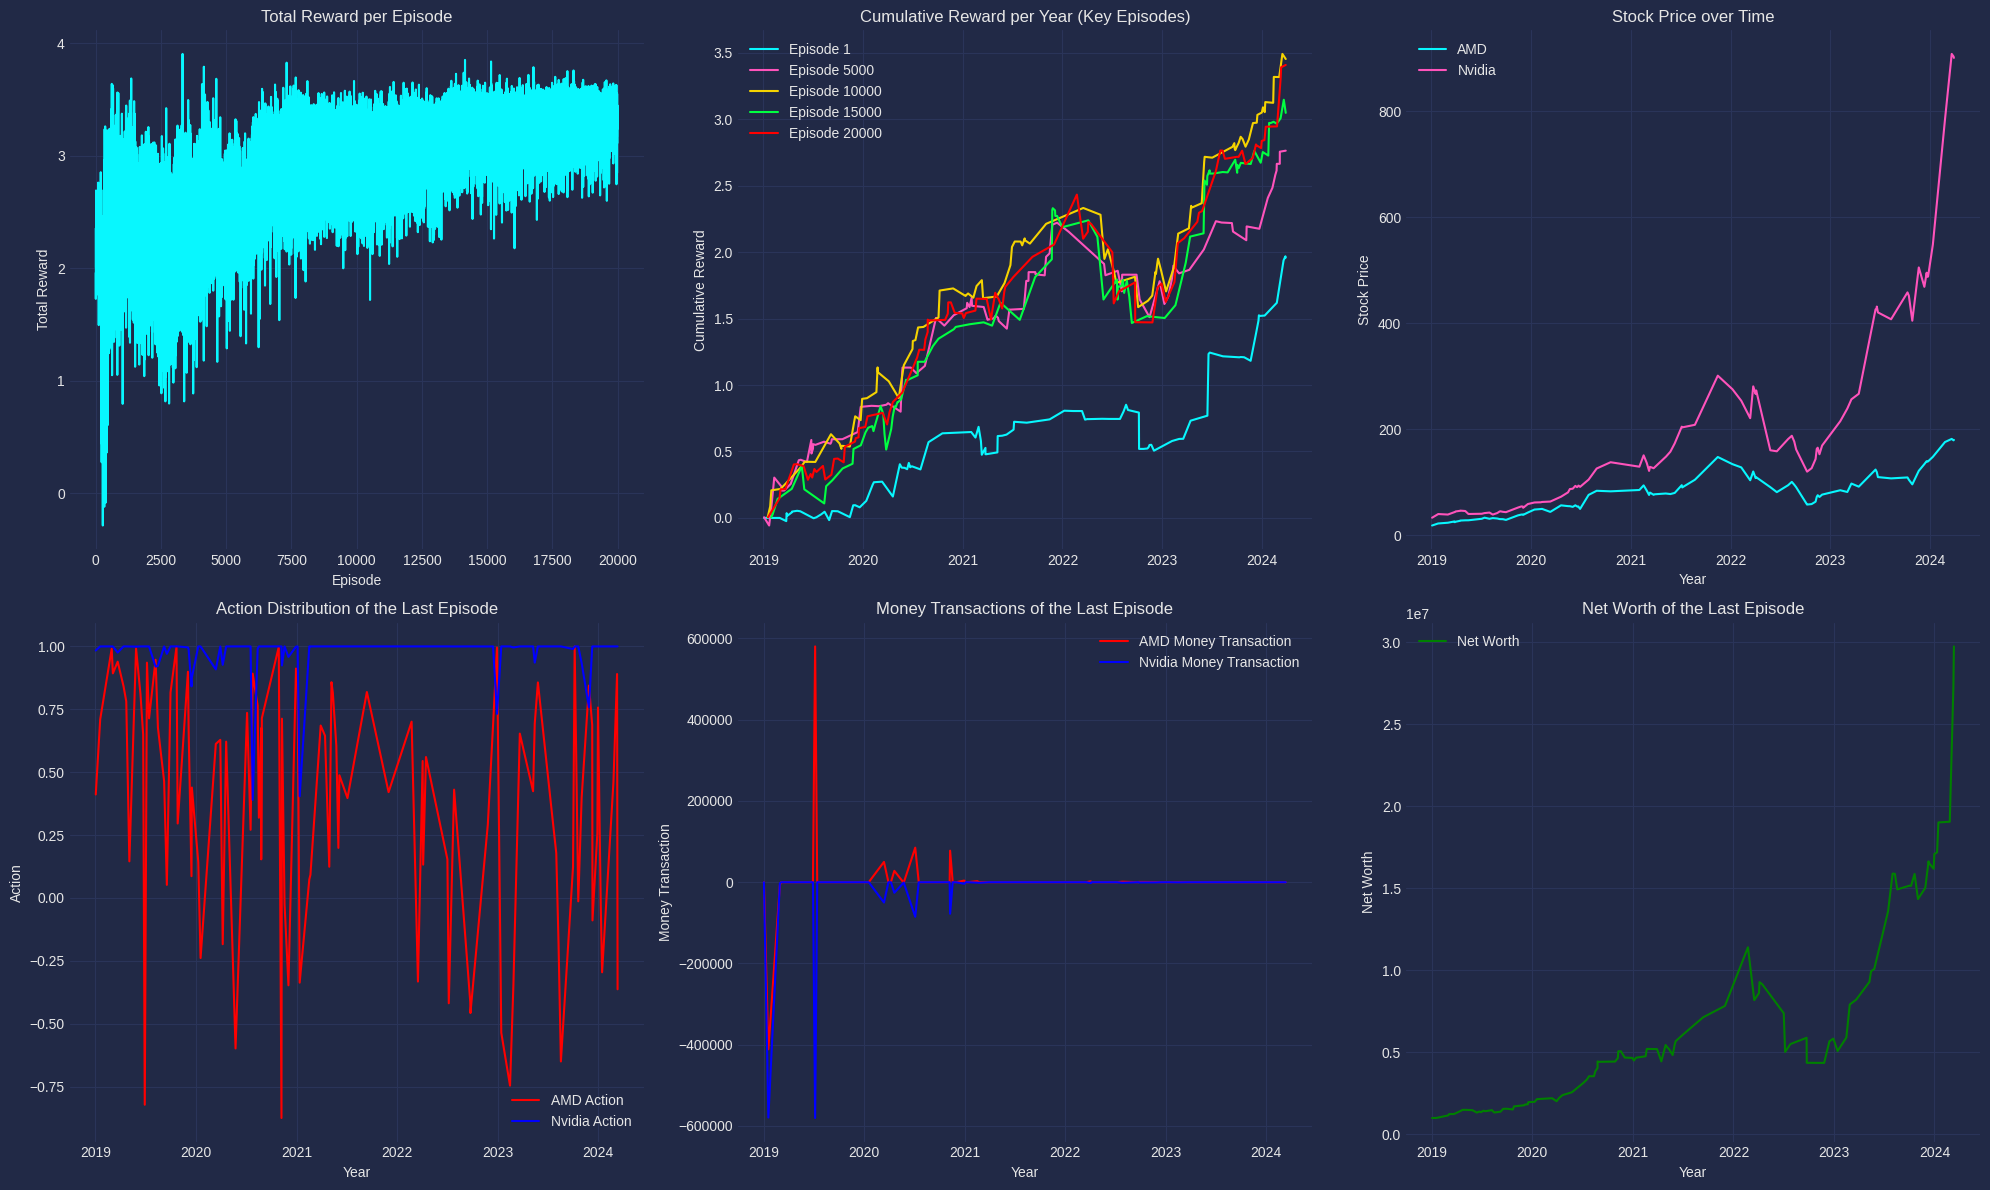

In [ ]:
# Train Complex LSTM Incorporated Policy Network with Baseline using the previously picked parameters

# Set the seed for reproducibility
seed = 6
set_seed(seed)

stock_data = StockData(df, lstm_amd, lstm_nvda, n_stocks=2)
complex_trader_env = ComplexTrader(stock_data)
initial_state = complex_trader_env.reset()
print(f"Initial state shape: {initial_state.shape}")

input_size = len(initial_state)
print(f"Input size to the network: {input_size}")

hidden_size = 64
output_size = stock_data.n_stocks

policy_network = PolicyNetwork(input_size, hidden_size, output_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.001)

value_network = ValueNetwork(input_size, hidden_size)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.001)

print("Training Time-series in Policy Gradient with Baseline and ComplexTrader...")
train_policy_gradient_with_baseline_complex(complex_trader_env, policy_network, value_network, policy_optimizer, value_optimizer, df, num_episodes=20000, sample_size=100, exploratory_level=0.1, no_action_penalty=1)